Note: this notebook joins all the smaller notebooks we have been working with ¡ to have a unified code base of the project. Some cell outputs are none for this reason, you can go to the archives and models folders and find the original notebooks.

# DATA EXTRACTION:

In [ ]:
import pandas as pd
import json

In [ ]:
import pandas as pd

weather_data = pd.DataFrame(columns=["date"])
for month in range(1,12+1):
    with open(f'data/jsons_weather_monthly/{str(month).zfill(2)}.json') as f:
        data = json.load(f)

    for daily in data["data"]["weather"]:
        hourly_data = []
        for hourly in daily["hourly"]:
            hourly_data.append(pd.DataFrame.from_dict(hourly))
        daily_data = pd.concat(hourly_data)
        daily_data["date"] = daily["date"]
        weather_data = pd.concat([weather_data, daily_data])

weather_data.to_csv("data/weather_hourly.csv")

## Combine the datasets in one csv file

### filter interesting columns

In [ ]:
weather_data = weather_data[['date', 'time', 'tempC','windspeedKmph','weatherCode','precipMM','humidity','pressure','cloudcover','WindChillC','WindGustKmph','FeelsLikeC','uvIndex']]

In [ ]:
import csv
import datetime
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Read weather data
weather_data = {}

with open("data/weather_hourly.csv", "r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        date = row["date"]
        time = row["time"]
        hour = int(time) // 100
        dt = datetime.datetime.strptime(date, "%Y-%m-%d").replace(hour=hour)
        weather_data[dt] = row
"""
# Read and encode occupation data
occupation_df = pd.read_csv("data/ocupacio_enginyeria_2022.csv")
columns_to_encode = ['Espai', 'Estudi', 'Activitat', 'Modalitat docencia']

#for col in columns_to_encode:
#    label_encoder = LabelEncoder()
#    occupation_df[col] = label_encoder.fit_transform(occupation_df[col].astype(str))

occupation_data = {}

for _, row in occupation_df.iterrows():
    if not row["Data inicial"].strip():  # Check if the date string is empty
        continue
    start_date = datetime.datetime.strptime(row["Data inicial"], "%d/%m/%Y")
    start_hour = int(row["Hora inicial"].split(":")[0])
    start_dt = start_date.replace(hour=start_hour)
    occupation_data[start_dt] = row.to_dict()

"""
# Read target data
target_data = {}

with open("data/Consum horari electricitat Enginyeries 2022.csv", "r") as f:
    reader = csv.DictReader(f, delimiter=";")
    for row in reader:
        date = datetime.datetime.strptime(row["Date"], "%d/%m/%Y")
        hour = int(row["Hour"].split(":")[0])
        dt = date.replace(hour=hour)
        target_data[dt] = row

# Merge the data
merged_data = []
for dt in sorted(weather_data.keys()):
    merged_row = weather_data[dt]
    """
    if dt in occupation_data:
        merged_row.update(occupation_data[dt])
    """
    if dt in target_data:
        merged_row.update(target_data[dt])

    merged_data.append(merged_row)

# Save the merged data to a CSV file
with open("data/merged_data.csv", "w", newline="") as f:
    fieldnames = set()
    for row in merged_data:
        fieldnames.update(row.keys())
    fieldnames = list(fieldnames)

    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    for row in merged_data:
        writer.writerow(row)

In [ ]:
merged_df = pd.read_csv("data/merged_data.csv")

In [ ]:
merged_df = pd.read_csv("data/merged_data.csv")

#columns_to_drop = ['Unnamed: 0', 'Data inicial', 'Data final', 'Hora inicial', 'Hora final', 'time', 'weatherIconUrl', 'winddir16Point', 'Date', 'Hour', 'Observacions', 'tempF', 'WindChillF', 'HeatIndexF', 'FeelsLikeF', 'DewPointF', 'WindGustMiles', 'visibilityMiles', 'pressureInches', 'precipInches']
columns_to_drop = ['Unnamed: 0', 'weatherIconUrl', 'winddir16Point', 'Date', 'Hour', 'tempF', 'WindChillF', 'weatherDesc','HeatIndexF', 'FeelsLikeF', 'DewPointF', 'WindGustMiles', 'visibilityMiles', 'pressureInches', 'precipInches']
merged_df = merged_df.drop(columns=columns_to_drop)
merged_df["time"] = merged_df["time"]/100
# Save the updated DataFrame to a new CSV file
coloms_with_coma_decimal = ["Q-Enginyeria (Cos Central) [kWh] [Q-Enginyeria]","Q-Enginyeria (Espina 4) [kWh] [Q-Enginyeria]","Q-Enginyeria (Química) [kWh] [Q-Enginyeria]"]
for col in coloms_with_coma_decimal:
    changed = []
    for i,val in enumerate(merged_df[col]):
        if val == val:
            changed.append(val.replace(",","."))
        else: #we got a nan. interpolate by having previous value
            changed.append(changed[-1])
    
    merged_df[col] = changed

merged_df.to_csv("data/updated_merged_data.csv", index=False)

In [ ]:
merged_df = pd.read_csv("data/updated_merged_data.csv")

In [ ]:
merged_df.columns

# Creating dataset class

# Creating and embedding for the title of activities

In [ ]:
import torch

The problem we have is that we have too many activities to create a one hot vector of each of them.
Second problem we have is that if we wanted to add a new activity this would break the model

In [ ]:
#All activities we have.
occupation_data

In the future it would be cool to create our own model that creates some embedding optimized for owr problem.

For now we'll use some pretrained.

In [ ]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [ ]:
start_token = "[CLS] "
end_token = " [SEP]"
test_txt = start_token + "This class is chaotic and boring at the same time. " + end_token
tokenized_text = tokenizer.tokenize(test_txt)
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
segments_ids = [1] * len(tokenized_text)

In [ ]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-multilingual-cased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()
model.to("mps")

In [ ]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens]).to("mps")
segments_tensors = torch.tensor([segments_ids]).to("mps")

In [ ]:
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers. 
with torch.no_grad():

    outputs = model(tokens_tensor, segments_tensors)

    # Evaluating the model will return a different number of objects based on 
    # how it's  configured in the `from_pretrained` call earlier. In this case, 
    # becase we set `output_hidden_states = True`, the third item will be the 
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[2]

In [ ]:
# `token_vecs` is a tensor with sha pe [Ntokens x 768]
token_vecs = hidden_states[-2][0] #second to last hiden layer

# Calculate the average of all Ntokens token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)
sentence_embedding.shape

In [ ]:
def sentence2hidden_states(txt):
    test_txt = start_token + txt + end_token
    tokenized_text = tokenizer.tokenize(test_txt)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text) 
    segments_ids = [1] * len(tokenized_text)

    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens]).to("mps")
    segments_tensors = torch.tensor([segments_ids]).to("mps")
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
    
    hidden_states = outputs[2]
    return hidden_states

Here we have an embedding for each sentence of size (768)

Now we'll try to apply kmeans to kluster all titles by their semantic meaning.

In [ ]:
from tqdm import tqdm 

In [ ]:
vectors = {}
h_states = {}
occupations = set()
for occu in tqdm(occupation_data["Activitat"]):
    if occu not in occupations:
        h = sentence2hidden_states(occu)[-2][0].to("cpu") #get all layers first batch
        h_states[occu] =h

        # Calculate the average of all Ntokens token vectors.
        sentence_embedding = torch.mean(h, dim=0)
        vectors[occu] = sentence_embedding.numpy()
        occupations.add(occu) 

We'll do the same but encode the classroom the activity is in the text also

In [ ]:
vectors_plus = {}
h_states_plus = {}
occupations_plus = set()
for occu, espai in zip(occupation_data["Activitat"],occupation_data["Espai"]):
    if occu + " " + espai not in occupations_plus:
        h = sentence2hidden_states(occu + " " + espai)[-2][0].to("cpu") #get all layers first batch
        h_states_plus[occu + " " + espai] = h
        
        # Calculate the average of all Ntokens token vectors.
        sentence_embedding = torch.mean(h, dim=0)
        vectors_plus[occu + " " + espai] = sentence_embedding.numpy()
        occupations_plus.add(occu + " " + espai) 

Save data to pickle file for later use

In [ ]:
import pickle

#bert_data = {
#    "single_ocu":{"mean_vect":vectors,"h_states":h_states},
#    "ocu_plus_space":{"mean_vect":vectors_plus,"h_states":h_states_plus}
#    }

bert_data = {
    "single_ocu":{"mean_vect":vectors},
    "ocu_plus_space":{"mean_vect":vectors_plus}
    }

# Open a file and use dump()
with open('data/bert_embedded.pkl', 'wb') as file:
      
    pickle.dump(bert_data, file)

We'll do some fast clustering to see if it makes any sense

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(list(vectors_plus.values()))
cluster_cent = kmeans.cluster_centers_

In [ ]:
cluster_map = pd.DataFrame()
cluster_map['data_index'] = list(vectors_plus.keys())
cluster_map['cluster'] = kmeans.labels_

In [ ]:
cluster_map[cluster_map["cluster"]==0].value_counts()

In [ ]:
cluster_map[cluster_map["cluster"]==1].value_counts()

In [ ]:
cluster_map[cluster_map["cluster"]==2].value_counts()

In [ ]:
cluster_map[cluster_map["cluster"]==3].value_counts()

We'll not sure if it makes any sense XD

We'll add to the dataset a column for the hiddent states of bert. We'll pass a text through bert if the input class doesn't exist.

# Creating dataset class

This class is also saved in a py file

In [ ]:
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
from sklearn import preprocessing 
import torch
import numpy as np
import pandas as pd
import pickle
import datetime

class energyProject_dataset(Dataset):
    def __init__(self,dataset_pth,occupacio_pth,bert_embeddings_pkl_pth,pca_pkl_pth=None):
        self.df = pd.read_csv(dataset_pth)
        with (open(bert_embeddings_pkl_pth, "rb")) as openfile:
            self.bert_embeddings = pickle.load(openfile)
        self.activitivity_encoding_mode = 0
        
        #order of values in target tensor will follow this
        self.target_labels = ["Q-Enginyeria (Cos Central) [kWh] [Q-Enginyeria]","Q-Enginyeria (Espina 4) [kWh] [Q-Enginyeria]","Q-Enginyeria (Química) [kWh] [Q-Enginyeria]"]
       
        #load occupation data
        self.occupation_df = pd.read_csv(occupacio_pth)
        #we'll remove entries without date
        self.occupation_df = self.occupation_df[self.occupation_df["Data inicial"] != " "]

        #convert date string to be in the form y-m-d instead of d/m/y
        #convert hour data to datetime object so we can compare them
        for i, row in self.occupation_df.iterrows(): 
            self.occupation_df.loc[i]["Data inicial"] =  datetime.datetime.strptime(self.occupation_df.loc[i]["Data inicial"], "%d/%m/%Y").strftime("%Y-%m-%d")
            self.occupation_df.loc[i]["Hora inicial"] = datetime.datetime.strptime(self.occupation_df.loc[i]["Hora inicial"] ,"%H:%M").time()
            self.occupation_df.loc[i]["Hora final"] = datetime.datetime.strptime(self.occupation_df.loc[i]["Hora final"] ,"%H:%M").time()
        
        self.ocup_vocab = list(set(self.occupation_df["Activitat"]))
        self.espais_vocab = list(set(self.occupation_df["Espai"]))
        #Add a padding occupation
        self.espais_vocab.append("NO ESPAI")

        #Normalize all climate data to be between 0-1
        #we'll keep their scaler objects so we can transform their values back to original
        #and not loose meaning.
        self.column_scalers = {}
        columns_to_process = ['winddirDegree', 'precipMM', 'visibility', 'WindChillC',
       'humidity', 'pressure','windspeedMiles', 'uvIndex', 'DewPointC',
       'FeelsLikeC', 'tempC','weatherCode','HeatIndexC', 'WindGustKmph', 'cloudcover',
       'windspeedKmph','Q-Enginyeria (Cos Central) [kWh] [Q-Enginyeria]',
       'Q-Enginyeria (Química) [kWh] [Q-Enginyeria]',
       'Q-Enginyeria (Espina 4) [kWh] [Q-Enginyeria]'] #normalze also target
     
        for col in columns_to_process:
            scaler, values = self.normalize_values(self.df[col])
            self.df[col] = values
            self.column_scalers[col] = scaler
        
        #If we want this dataset to work with batches in modes different than 0 and 1.
        #We need to know what is the maximum number of activities at the same time so we can
        #padd the samples smaller. We need the batch to have the same shape samples every time.

        #we'll use that we are iterating throught this to compute all the one_hot vectors of the encodings
        #and fit a PCA object so we can have it with dimensionality reduction.

        self.max_ocu_lenght = 0
        self.all_one_hots = []
        for i, row in self.df.iterrows():
            day2day_ocu = self.activty_class_perT(row["date"],row["time"])
            
            #find largest occupation size per hour
            day2day_ocu_l = len(day2day_ocu)
            if day2day_ocu_l > self.max_ocu_lenght:
                self.max_ocu_lenght = day2day_ocu_l
                
            if pca_pkl_pth == True: #if we have to calculate the PCA
                #compute one_hot vectors of occupation at this time
                self.all_one_hots.append(self.activity_class_one_hot(day2day_ocu))
        
        if (pca_pkl_pth == True): #nan value, recalculate and save file
            self.all_one_hots = np.array(self.all_one_hots)
            #compute PCA on all the one_hot vectors
            self.ocu_one_hot_pca = PCA(n_components=1000) #1000 size output vector (number chosen by hand)
            self.ocu_one_hot_pca.fit(self.all_one_hots)
            # Open a file and use dump()
            with open('data/pca_occupation.pkl', 'wb') as file:
                pickle.dump(self.ocu_one_hot_pca, file)
        else:
            with (open(pca_pkl_pth, "rb")) as openfile:
                self.ocu_one_hot_pca = pickle.load(openfile)
        
        ##free memory by removing unnecessary variables.
        del self.all_one_hots

    def normalize_values(self,x):
        """
        Input a list of values
        Output a sklearn scaler object and the list normalized.
        We need to keep the scaler to be able to re-scale the data back and now what value it is in reality.
        """
        to_scale = np.array(x).reshape(-1, 1) #the library needs this extra dimensions trick to interpret properly
        min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
        x_scaled = min_max_scaler.fit_transform(to_scale)
        return min_max_scaler, x_scaled
    
    def denormalize_values(self,x_n,scaler):
        """
        Given some set of values and a sklearn scaler object
        Transform back the values to their original "space"ArithmeticError
        return: set of values same shape as input
        """
        to_scale = np.array(x_n).reshape(-1, 1)
        return scaler.inverse_transform(to_scale)

    def datetime_enc(self,date, time)->torch.tensor:
        """
        Encodes incoming date and time strings as two values for each that 
        come from infering the index value on a sin function and cos function.
        Its nice beacause we encode the smoothness and circularity of the trigonometric
        functions.

        input <- (date: str, time:str)
        output -> (torch.tensor((1,5)))
        """
        
        date_obj =  datetime.datetime.strptime(date, "%Y-%m-%d")
        
        #encode year as floas
        year_enc = float(date_obj.year)/1000 # divide by 100 to have reasonable value
        
        ##
        ##Encoding: (sin, cos) value for each day month
        ##
        idx_d = date_obj.timetuple().tm_yday #day of the year number
        date_enc= [np.sin((idx_d/365) * 2*np.pi),np.cos((idx_d/365) * 2*np.pi)]  #365 days a yar +1 offset so we don't have negative value
        
        #encode time by hour in the day
        time_enc = [np.sin((time/24) * 2*np.pi),np.cos((time/24) * 2*np.pi)]  #24 hours a day. +1 offset so we don't have negative values
        
        return torch.tensor([year_enc]+date_enc+time_enc) 

    def datetime_dec(self,enc_tens):
        """
        Decodes incoming encoded date and time tensor as the two respective
        date time string values

        input <- (torch.tensor([torch.float,torch.float]))
        output -> date: str, time:str
        """
        #decode year
        year = int(enc_tens[0].item() * 1000)

        #decode date
        penc_date = np.arctan2(enc_tens[1].item(),enc_tens[2].item()) / (2*np.pi) * 365
        date = datetime.datetime(year, 1, 1) + datetime.timedelta(penc_date - 1)
        date = date.strftime("%Y-%m-%d")

        #decode time
        time = np.round((np.arctan2(enc_tens[3].item(),enc_tens[4].item()) / (2*np.pi) * 24)% 24)
        
        return date,time

    def activty_class_perT(self,date,time)->pd.DataFrame:
        """
        Returns slice of the pd Dataframe of activities active given some date and time
        """
        #filter dataset to see activities that day
        day2day_ocu = self.occupation_df[self.occupation_df["Data inicial"] == date ] 
        h = datetime.time(int(time))
        hour2hour_ocu = day2day_ocu[(day2day_ocu["Hora inicial"] <= h) & (day2day_ocu["Hora final"] > h)]
        return pd.DataFrame(hour2hour_ocu)

    def activity_class_one_hot(self,activities)->np.array:
        """ 
        returns flattenned coocurrence one-hot matrix of activities and classrooms
        """
        occurrence_matrix = np.zeros((len(self.ocup_vocab),len(self.espais_vocab)))
        for i,actv in activities.iterrows(): #iterate found activities
            ocup_idx = self.ocup_vocab.index(actv["Activitat"])
            espais_idx = self.espais_vocab.index(actv["Espai"])
            occurrence_matrix[ocup_idx,espais_idx] = 1
            
        #now flatten the occurrence matrix into a one hot vector
        one_hot = occurrence_matrix.flatten()
        return one_hot
    
    def class_one_hot(self,activitats)->torch.tensor:
        """
        Returns "one hot" encoding of activitat.
        In reality will not be a true one hot but a list of indexes
        that can later on be passed to some embedding layer
        """
        activitats["Espai"]
        one_hot_esp = [self.espais_vocab.index(key) for key in activitats["Espai"]]
        return torch.tensor(one_hot_esp)
       


    def __len__(self):
        return len(self.df) 
    
    def __getitem__(self, index):
        """
        This function will return more than one object depending on the mode it is on.
        Activity encoding mode:
            0: I.very large one-hot encoding of all the combinations of classroom and activity concatenated
                with all other features.
               II. target values
            
            1:  I. 0 but first with some PCA applied to reduce dimensionality of 
                the enormous one-hot encoding.
                II. target values
            
            2: returns four objects, 
                I.mean_encoding of activity from bert(as many as activities at time stamp), 
                II. classroom one hot encoding for each activity(as many as activities at time stamp)
                III. All other features at that time stamp
                IV. target values
            
            2.5:  returns four objects
                I. embedding tensor of activity from bert(as many as activities at time stamp), 
                II. classroom one hot encoding for each activity(as many as activities at time stamp)
                III. All other features at that time stamp
                IV. target values
            
            3: returns three objects,
                I. mean encoding of activity, classroom pair through bert (as many as activities at time stamp),
                II. All other features at that time stamp
                III. target values
            
            3.5:  returns four objects
                I. embedding tensor of activity, classroom pair through bert(as many as activities at time stamp), 
                II. classroom one hot encoding for each activity(as many as activities at time stamp)
                III. All other features at that time stamp
                IV. target values
            
            4: returns three objects, raw data thought for model handling.
                I. activities in text form paired with their classroom
                II. All other features at that time stamp
                III. target values
        """

        #get row in df for data to be evaluated:
        row = self.df.iloc[index]

        #First getting the "all other data " features tensor
        #Date-time encoding tensor
        enc_dt_tens = self.datetime_enc(row["date"],row["time"]) #date-time encoding

        #weather data tensor
        weather_tens = torch.tensor(row.drop(["date","time","Q-Enginyeria (Cos Central) [kWh] [Q-Enginyeria]","Q-Enginyeria (Espina 4) [kWh] [Q-Enginyeria]","Q-Enginyeria (Química) [kWh] [Q-Enginyeria]"]))

        #second get the target values tensor
        target_tens = torch.tensor(row[self.target_labels])
        
        #Get activities at given time and date
        activities = self.activty_class_perT(row["date"],row["time"])
        if self.activitivity_encoding_mode <= 1:
            one_hot = self.activity_class_one_hot(activities)
            
            if(self.activitivity_encoding_mode == 0):
                one_hot = torch.tensor(one_hot)
                #return values
                sample = {'x': torch.cat((enc_dt_tens,weather_tens,one_hot),axis=0), 'y': target_tens}
                return sample
            
            if(self.activitivity_encoding_mode == 1):
                one_hot = one_hot.reshape(1, -1) #create extra dimension because this counts as only one sample
                smaller_x = torch.tensor(self.ocu_one_hot_pca.transform(one_hot))[0] #get rid of extra dim
                sample = {'x': torch.cat((enc_dt_tens,weather_tens,smaller_x),axis=0), 'y': target_tens}
                return sample
        
        if self.activitivity_encoding_mode == 2:
            #get bert embeddings
            emb_activ = []
            for i,actv in activities.iterrows(): #iterate found activities   
                emb_activ.append(self.bert_embeddings["ocu_plus_space"]["mean_vect"][actv["Activitat"] + " " + actv["Espai"]])
            emb_activ = torch.tensor(np.array(emb_activ))

            #get espai one-hot
            espai_one_hot = self.class_one_hot(activities)

            #padd with occupation 0 vector so all samples are same shape and espai with ""NO ESPAI"
            if emb_activ.shape[0] < self.max_ocu_lenght: 
                emb_activ = torch.cat((emb_activ,torch.zeros((self.max_ocu_lenght-emb_activ.shape[0],768))),axis=0)
                espai_padd = pd.DataFrame(columns=["Espai"]) 
                espai_padd["Espai"] = ["NO ESPAI"]* (self.max_ocu_lenght-len(espai_one_hot))
                padd_one_hot = self.class_one_hot(espai_padd)
                espai_one_hot = torch.cat((espai_one_hot,padd_one_hot))
                
            sample = {'ocu_ber_emb': emb_activ,'espai_enc':espai_one_hot, "general_data":torch.cat((enc_dt_tens,weather_tens),axis=0), 'y': target_tens}
            return sample
        
        if self.activitivity_encoding_mode == 2.5:
            assert "NOT IMPLEMENTED YET"
            pass
            
        if self.activitivity_encoding_mode == 3:
            emb_activ = []
            for i,actv in activities.iterrows(): #iterate found activities   
                emb_activ.append(self.bert_embeddings["ocu_plus_space"]["mean_vect"][actv["Activitat"] + " " + actv["Espai"]])
            emb_activ = torch.tensor(np.array(emb_activ))

            if emb_activ.shape[0] < self.max_ocu_lenght: #padd with occupation 0 vector so all samples are same shape
                emb_activ = torch.cat((emb_activ,torch.zeros((self.max_ocu_lenght-emb_activ.shape[0],768))),axis=0)
            
            #return values
            sample = {'activ': torch.tensor(emb_acti), 'general_data':torch.cat((enc_dt_tens,weather_tens),axis=0), 'y': target_tens}
            return sample
        
        if self.activitivity_encoding_mode == 3.5:
            assert "NOT IMPLEMENTED YET"
            #errors to solve have to recalculate bert passing
            emb_acti = []
            for i,actv in activities.iterrows(): #iterate found activities   
                emb_acti.append(self.bert_embeddings["ocu_plus_space"]["h_states"][actv["Activitat"] + " " + actv["Espai"]])
                print(self.bert_embeddings["ocu_plus_space"]["h_states"][actv["Activitat"] + " " + actv["Espai"]].shape)
            emb_acti = torch.tensor(emb_acti)
            
            print(emb_acti.shape)
            #return values
            return torch.tensor(emb_acti), torch.cat((enc_dt_tens,weather_tens),axis=0) , target_tens

        if self.activitivity_encoding_mode == 4:
            acti = list(activities["Activitat"])
            esp = list(activities["Espai"])

            if len(acti) < self.max_ocu_lenght: #padd with occupation 0 vector so all samples are same shape
                pad = ["NONE"] * (self.max_ocu_lenght-len(acti))
                acti += pad
                esp += pad

            sample = {"activ:":acti, "espai": esp,"general_data":torch.cat((enc_dt_tens,weather_tens),axis=0),'y': target_tens}
            return sample

In [ ]:
dataset = energyProject_dataset("data/updated_merged_data.csv","data/ocupacio_enginyeria_2022.csv","data/bert_embedded.pkl",True)

Lets see a sample in the default output mode just to see

In [ ]:
dataset.activitivity_encoding_mode = 4
dataset.__getitem__(0)

Save dataset as pickle so we don't have to run init every time and it is only one file to handle

In [ ]:
# Open a file and use dump()
with open('data/dataset_class.pkl', 'wb') as file:
    pickle.dump(dataset, file)

# LSTM model initial experiments:

In [1]:
#import dataset class
from dataset import energyProject_dataset
from torch.utils.data import DataLoader
import pickle
import torch
import torch.nn as nn
import numpy as np
import tqdm
import torch
import torch.nn as nn
import pandas as pd
import yaml

In [2]:
#load dataset object file
with (open('data/dataset_class.pkl', "rb")) as openfile:
    dataset = pickle.load(openfile)

In [7]:
#now you can create a dataloader and use it!
dataloader = DataLoader(dataset, batch_size=100, shuffle=False)
dataset.activitivity_encoding_mode = 2 #or any value

In [4]:
dataset.__getitem__?

Signature: dataset.__getitem__(index)
Docstring:
This function will return more than one object depending on the mode it is on.
Activity encoding mode:
    0: I.very large one-hot encoding of all the combinations of classroom and activity concatenated
        with all other features.
       II. target values
    
    1:  I. 0 but first with some PCA applied to reduce dimensionality of 
        the enormous one-hot encoding.
        II. target values
    
    2: returns four objects, 
        I.mean_encoding of activity from bert(as many as activities at time stamp), 
        II. classroom one hot encoding for each activity(as many as activities at time stamp)
        III. All other features at that time stamp
        IV. target values
    
    2.5:  returns four objects
        I. embedding tensor of activity from bert(as many as activities at time stamp), 
        II. classroom one hot encoding for each activity(as many as activities at time stamp)
        III. All other features at t

batch of 100:

In [8]:
from icecream import ic

In [3]:
BERT_DIM_EMB = 768
TIME_CLIMATE_DIM = 21
import torch.nn.init as init
#classe = activitat + espai encoded

class attentive_model_pepemarti(nn.Module):
    def __init__(self, espai_emb_dim,hidden_dim,lstm_nl,target_dim):
        super(attentive_model_pepemarti, self).__init__()
        self.espai_emb_dim = espai_emb_dim
        self.hidden_dim = hidden_dim
        self.lstm_nl = lstm_nl

        self.espai_emb = nn.Embedding(num_embeddings=len(dataset.espais_vocab),embedding_dim=espai_emb_dim)
        self.classe_repr = nn.Sequential(
            nn.Linear(in_features=BERT_DIM_EMB+espai_emb_dim,out_features=601),
            nn.ReLU(),
            nn.Linear(in_features=601,out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256,out_features=51),
            nn.ReLU(),
            nn.Linear(in_features=51,out_features=TIME_CLIMATE_DIM),
            nn.Softmax(dim=-1)
        )

        self.key_gen =  nn.Sequential(
            nn.Linear(in_features=TIME_CLIMATE_DIM,out_features=40),
            nn.ReLU(),
            nn.Linear(in_features=40,out_features=hidden_dim),
            nn.ReLU(),
        )

        self.val_gen =  nn.Sequential(
            nn.Linear(in_features=TIME_CLIMATE_DIM,out_features=40),
            nn.ReLU(),
            nn.Linear(in_features=40,out_features=hidden_dim),
            nn.ReLU(),
        )

        self.query_gen =  nn.Sequential(
            nn.Linear(in_features=TIME_CLIMATE_DIM,out_features=40),
            nn.ReLU(),
            nn.Linear(in_features=40,out_features=hidden_dim),
            nn.ReLU(),
        )
        
        self.multihead_attn = nn.MultiheadAttention(hidden_dim,3,batch_first=True)
        
        self.lstm = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=self.lstm_nl, dropout=0, batch_first=True) #input -> BATCH, SEQ_LENGHT, EMBEDDING_DIM
        
        self.regressFC = nn.Sequential(
            nn.Linear(in_features=self.hidden_dim,out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64,out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256,out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64,out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16,out_features=target_dim),
            nn.ReLU(),
        )

    def forward(self,ocu_ber_emb,espai_enc,general_data,h,c):
        #embedd the espais
        espai_emb = self.espai_emb(espai_enc.to(torch.int)).float()
        #concatenate activity and espai vector
        act_cat_espai = torch.cat((ocu_ber_emb,espai_emb),axis=2)

        #pass act_cat_espai through a FC to have a "classe" representation
        classe_repr = self.classe_repr(act_cat_espai.float())
    
        #get this representation and multiply it with the general data "sort of attention here"
        #first extend the general data so we have a pair for each class vector
        general_rep = general_data.unsqueeze(1).repeat(1, 34, 1)
        general_at_per_class = general_rep * classe_repr #element wise multiplication
        general_at_per_class = general_at_per_class.float() #convert to float32

        key = self.key_gen(general_at_per_class) #generate key with FC
        value = self.val_gen(general_at_per_class) #generate value with FC
        query = self.query_gen(general_at_per_class) #generate query with FC
        
        #att_mask = torch.sum(ocu_ber_emb,axis=2) != 0.0 #look for what values have to enter. The ones that aren't padding
        #att_mask = att_mask.unsqueeze(1)
        #att_mask = att_mask.repeat(3, att_mask.shape[2], 1)#repeat 3 times along batch dim because we have three heads. The other repeat is because we need it to be of shape seqlenxseqlen 
        #output, _ =  self.multihead_attn(key=key, value=value, query=query,attn_mask=att_mask)
        output, _ =  self.multihead_attn(key=key, value=value, query=query)
        output = torch.sum(output,axis=1)

        #create extra to output be a sequence of 1
        output = output.unsqueeze(1)
        
        #pass this as the inital state to a LSTM
        out, (h,c) = self.lstm(output, (h,c))
        out =  self.regressFC(out).float()
        return out, h, c
    
    def init_hidden(self,batch_size):
        # Initialize the hidden state and cell state with zeros
        h = torch.zeros(self.lstm_nl, batch_size, self.hidden_dim,dtype=torch.float32)
        c = torch.zeros(self.lstm_nl, batch_size, self.hidden_dim,dtype=torch.float32)
        return h, c

    def init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)
    

Define train function:

In [10]:
device = "mps"

In [8]:
model = attentive_model_pepemarti(espai_emb_dim=30,hidden_dim=30,lstm_nl=1,target_dim=1)

In [9]:
model.init_weights()

In [10]:
model = model.to(device)

In [11]:
#now you can create a dataloader and use it!
batch_size = 100
dataloader = DataLoader(dataset, batch_size, shuffle=False)

In [12]:
import torch.optim as optim
def train(dataloader, model, batch_size, num_epochs,lr=0.001,y_idx=0):
    model.train()

    criterion =  nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []
    for epoch in range(num_epochs):
        for batch, data in enumerate(dataloader):
            ocu_emb, espai_enc, general_data = data["ocu_ber_emb"].float().to(device) ,data["espai_enc"].float().to(device) ,data["general_data"].float().to(device)
            y = data["y"][:,y_idx].float().to(device) #we'll do one counter for now
            optimizer.zero_grad()

            #current batch size size
            b_sz = ocu_emb.shape[0]

            #note the dataloader with a batch of 100 when reachs the end expects a batch of 60
            h, c = model.init_hidden(b_sz) # Start with a new state in each batch            
            h = h.to(device)
            c = c.to(device)
            y_pred, h,c= model(ocu_emb, espai_enc, general_data, h, c)
            y_pred = y_pred[:,0,0]
            loss = criterion(y_pred,y)  #cross entropy loss needs (N,C,seq_lenght)
            loss.backward()
            optimizer.step()

            if batch%30 == 0:
                print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })
                losses.append(loss.item())
    return losses

In [12]:
num_epochs = 40
losses = train(dataloader, model, batch_size=100, num_epochs=num_epochs)


KeyboardInterrupt



In [14]:
torch.save(model, "models/attention_exp_LSTM/model1.pth")

In [10]:
model = torch.load( "models/attention_exp_LSTM/model1.pth")

In [23]:
import matplotlib.pyplot as plt
# Visualize the loss evolution during training
plt.plot(losses)
plt.title('model loss')
plt.show()

NameError: name 'losses' is not defined

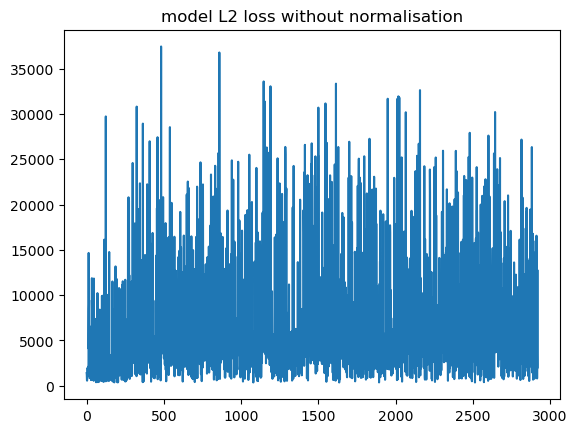

In [46]:
scaler = dataset.column_scalers[dataset.target_labels[0]]
#get the simple loss back from the squared error
scaled_losses = np.ravel(np.power(dataset.denormalize_values(np.sqrt(losses),scaler),2))
plt.plot(scaled_losses)
plt.title('model L2 loss without normalisation')
plt.show()

In [61]:
#now you can create a dataloader and use it!
dataloader = DataLoader(dataset, len(dataset), shuffle=False)

In [62]:
#visualize the model predictions
from tqdm import tqdm
real = []
pred = []
h, c = model.init_hidden(dataloader.batch_size) # Start with a new state in each batch            
h = h.to(device)
c = c.to(device)
for batch, data in tqdm(enumerate(dataloader),total=len(dataloader)):
    with torch.no_grad():
        #current batch size size
        ocu_emb, espai_enc, general_data = data["ocu_ber_emb"].float().to(device) ,data["espai_enc"].float().to(device) ,data["general_data"].float().to(device)
        y = data["y"][:,0].float().to(device) #we'll do one counter for now
        
        b_sz = ocu_emb.shape[0]
        h, c = model.init_hidden(b_sz) # Start with a new state in each batch            
        h = h.to(device)
        c = c.to(device)

        y_pred, h,c= model(ocu_emb, espai_enc, general_data, h, c)
        pred += list(y_pred[:,0,0].to("cpu"))
        real += list(y.to("cpu"))

100%|██████████| 1/1 [00:22<00:00, 22.26s/it]


In [13]:
def predict_consumption(model,dataloader,y_idx):
    real = []
    pred = []
    h, c = model.init_hidden(dataloader.batch_size) # Start with a new state in each batch            
    h = h.to(device)
    c = c.to(device)
    for batch, data in enumerate(dataloader):
        with torch.no_grad():
            #current batch size size
            ocu_emb, espai_enc, general_data = data["ocu_ber_emb"].float().to(device) ,data["espai_enc"].float().to(device) ,data["general_data"].float().to(device)
            y = data["y"][:,y_idx].float().to(device) #we'll do one counter for now
            
            b_sz = ocu_emb.shape[0]
            h, c = model.init_hidden(b_sz) # Start with a new state in each batch            
            h = h.to(device)
            c = c.to(device)

            y_pred, h,c= model(ocu_emb, espai_enc, general_data, h, c)
            pred += list(y_pred[:,0,0].to("cpu"))
            real += list(y.to("cpu"))
    return real ,pred

In [63]:
real = [v.item() for v in real]
pred = [v.item() for v in pred]

In [64]:
scaler = dataset.column_scalers[dataset.target_labels[0]]
real_sc = dataset.denormalize_values(real,scaler)
pred_sc = dataset.denormalize_values(pred,scaler)

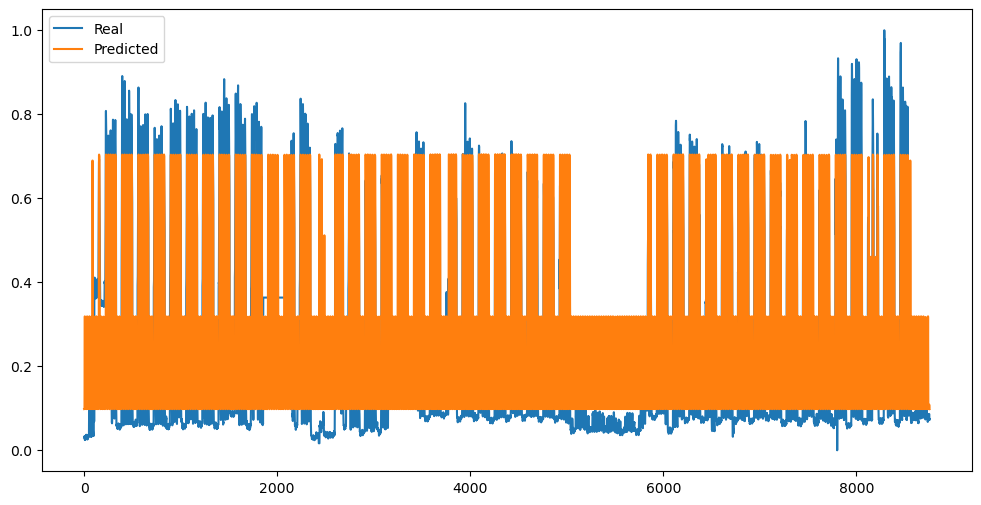

In [65]:
plt.figure(figsize=(12, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(real, label='Real')  # Add a label for the real data
plt.plot(pred, label='Predicted')  # Add a label for the predicted data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

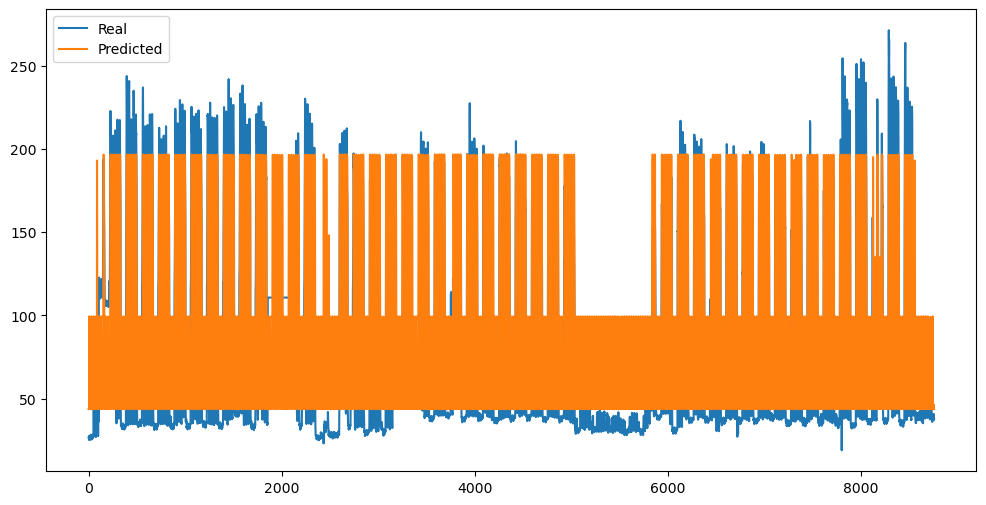

In [66]:
plt.figure(figsize=(12, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(real_sc, label='Real')  # Add a label for the real data
plt.plot(pred_sc, label='Predicted')  # Add a label for the predicted data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

Residual plot:

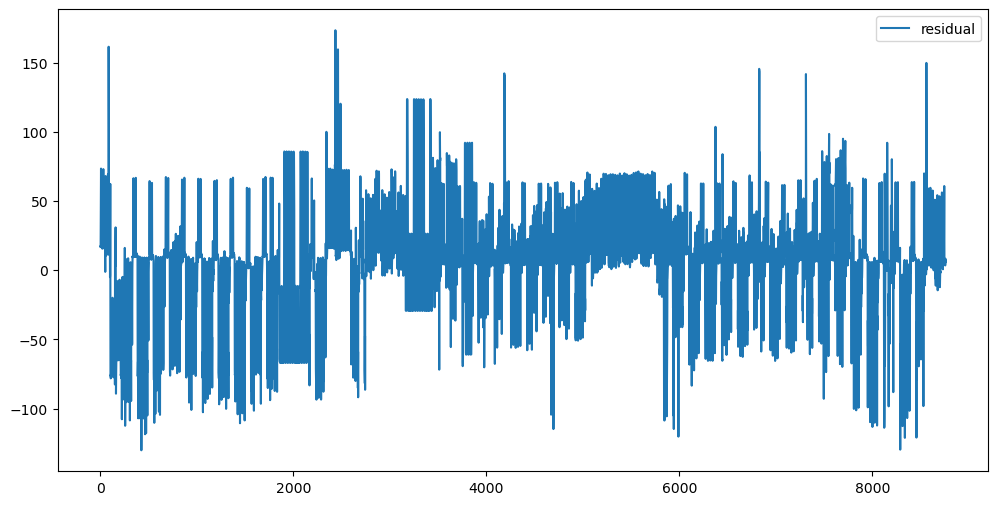

In [67]:
plt.figure(figsize=(12, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(pred_sc-real_sc, label='residual')  # Add a label for the real data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

### Try training with shuffle on and batchsize 1 so it is independent of past samples

Training on top of previous

In [11]:
#now you can create a dataloader and use it!
dataloader = DataLoader(dataset, 1, shuffle=True)

In [12]:
num_epochs = 10
losses = train(dataloader, model, batch_size=1, num_epochs=num_epochs,lr=0.0003)

{'epoch': 0, 'batch': 0, 'loss': 0.0020618834532797337}
{'epoch': 0, 'batch': 30, 'loss': 0.04694126173853874}
{'epoch': 0, 'batch': 60, 'loss': 0.04783538356423378}
{'epoch': 0, 'batch': 90, 'loss': 0.0013884382788091898}
{'epoch': 0, 'batch': 120, 'loss': 0.008989955298602581}
{'epoch': 0, 'batch': 150, 'loss': 0.00043730298057198524}
{'epoch': 0, 'batch': 180, 'loss': 0.006954110227525234}
{'epoch': 0, 'batch': 210, 'loss': 0.011619145050644875}
{'epoch': 0, 'batch': 240, 'loss': 0.010035841725766659}
{'epoch': 0, 'batch': 270, 'loss': 0.0001760736631695181}
{'epoch': 0, 'batch': 300, 'loss': 0.006977028213441372}
{'epoch': 0, 'batch': 330, 'loss': 0.0026083020493388176}
{'epoch': 0, 'batch': 360, 'loss': 0.003291620407253504}
{'epoch': 0, 'batch': 390, 'loss': 0.0014333856524899602}
{'epoch': 0, 'batch': 420, 'loss': 0.10546589642763138}
{'epoch': 0, 'batch': 450, 'loss': 0.0016184899723157287}
{'epoch': 0, 'batch': 480, 'loss': 0.13097260892391205}
{'epoch': 0, 'batch': 510, 'loss

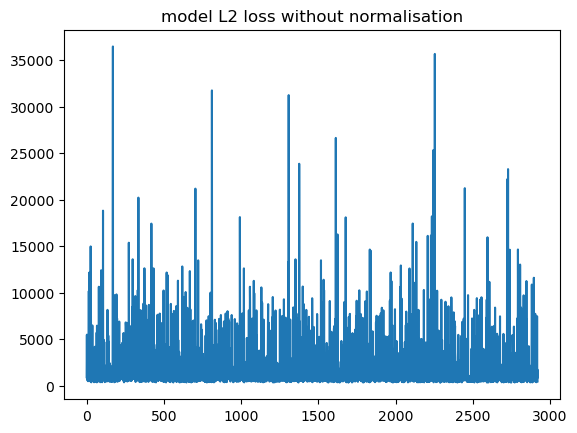

In [14]:
import matplotlib.pyplot as plt
scaler = dataset.column_scalers[dataset.target_labels[0]]
#get the simple loss back from the squared error
scaled_losses = np.ravel(np.power(dataset.denormalize_values(np.sqrt(losses),scaler),2))
plt.plot(scaled_losses)
plt.title('model L2 loss without normalisation')
plt.show()

Visualize how it predicts without seeing the past

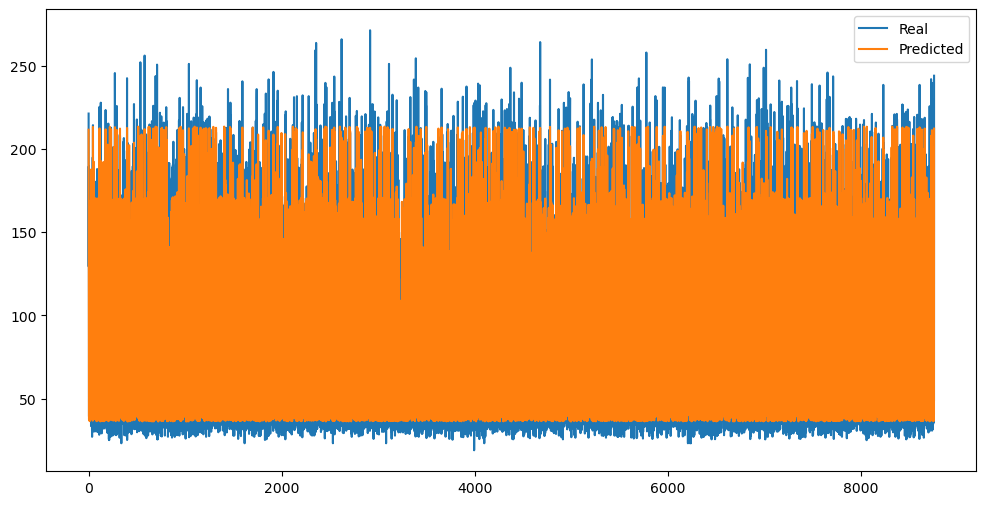

In [17]:
real, pred = predict_consumption(model,dataloader)
real = [v.item() for v in real]
pred = [v.item() for v in pred]
scaler = dataset.column_scalers[dataset.target_labels[0]]
real_sc = dataset.denormalize_values(real,scaler)
pred_sc = dataset.denormalize_values(pred,scaler)
plt.figure(figsize=(12, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(real_sc, label='Real')  # Add a label for the real data
plt.plot(pred_sc, label='Predicted')  # Add a label for the predicted data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

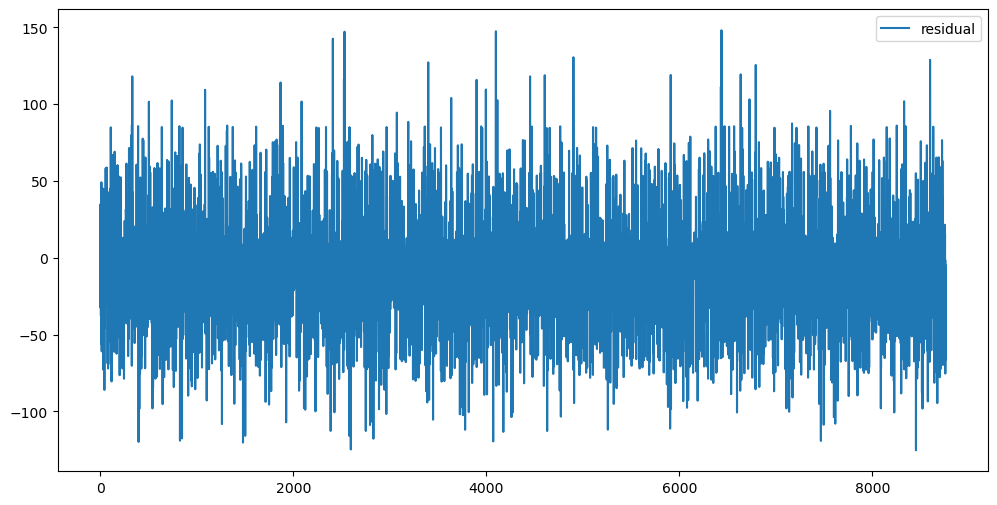

In [18]:
plt.figure(figsize=(12, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(pred_sc-real_sc, label='residual')  # Add a label for the real data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

And how it performs at the same task as before? (seeing past data continuosly)

In [19]:
#now you can create a dataloader and use it!
dataloader = DataLoader(dataset, len(dataset), shuffle=False)

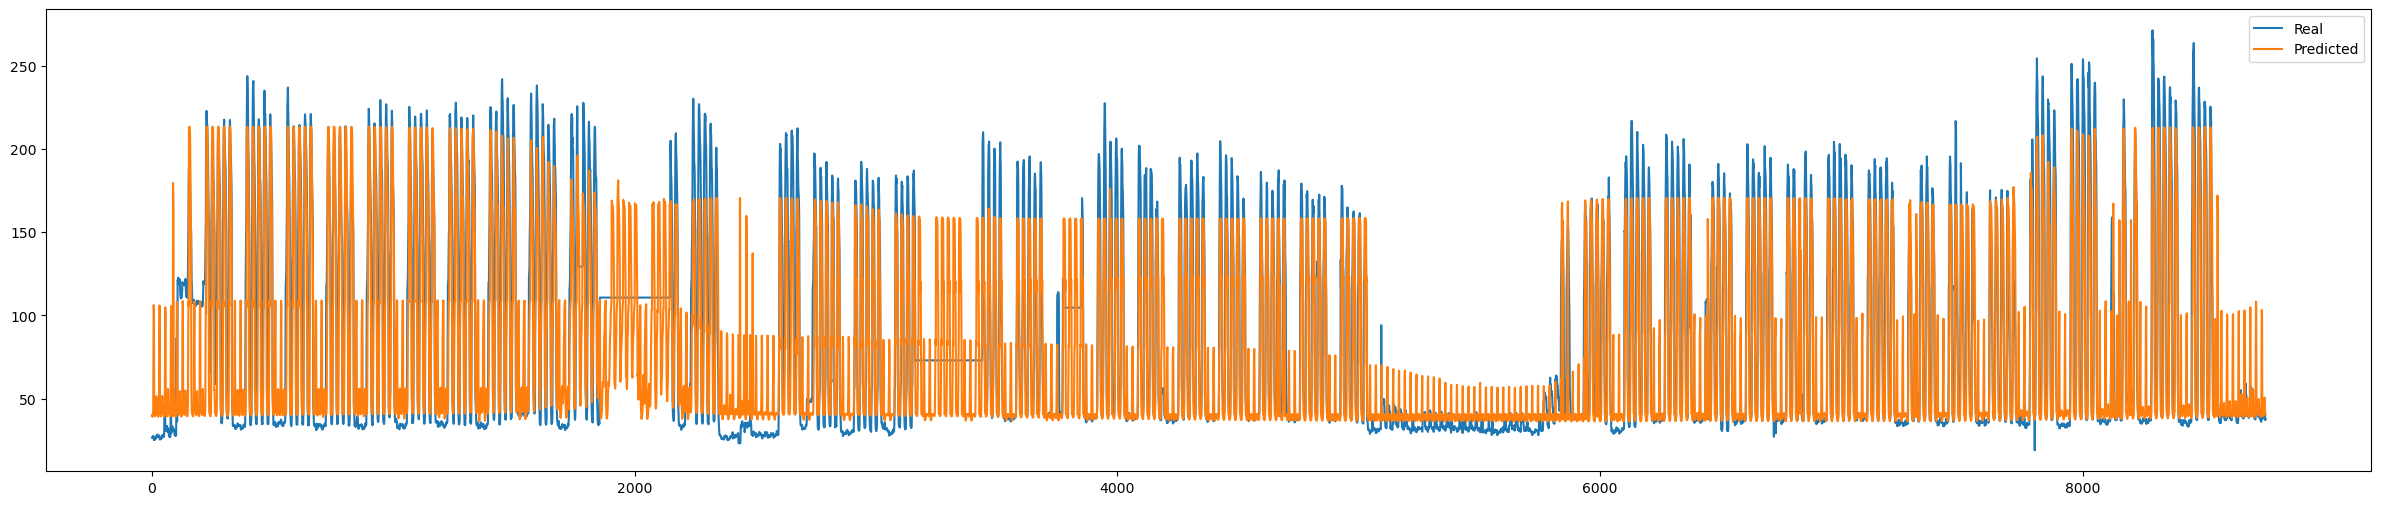

In [20]:
real, pred = predict_consumption(model,dataloader)
real = [v.item() for v in real]
pred = [v.item() for v in pred]
scaler = dataset.column_scalers[dataset.target_labels[0]]
real_sc = dataset.denormalize_values(real,scaler)
pred_sc = dataset.denormalize_values(pred,scaler)
plt.figure(figsize=(30, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(real_sc, label='Real')  # Add a label for the real data
plt.plot(pred_sc, label='Predicted')  # Add a label for the predicted data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

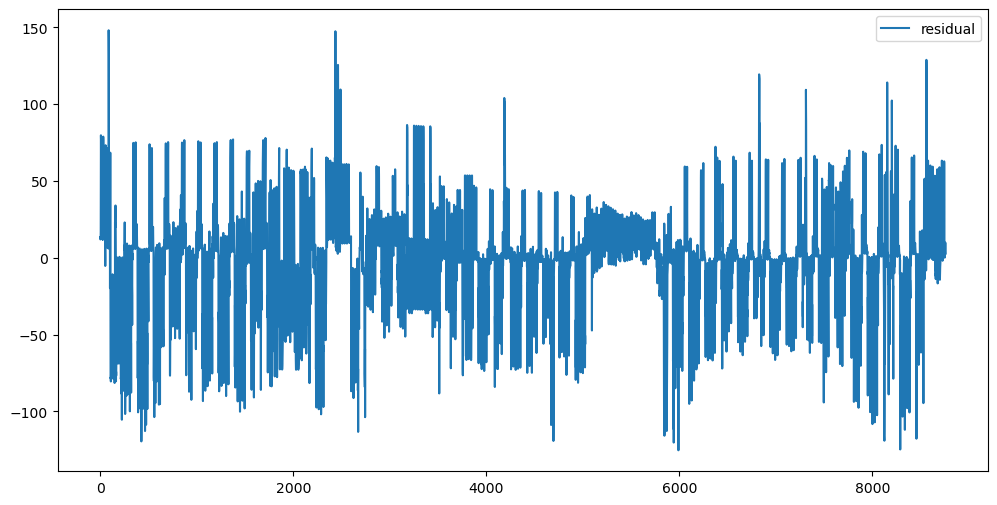

In [21]:
plt.figure(figsize=(12, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(pred_sc-real_sc, label='residual')  # Add a label for the real data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

Did help "fine tune" and learn importance of the daily information

In [22]:
torch.save(model, "models/attention_exp_LSTM/model1_ft.pth")

### How well does it perform if we train it for half a year or so and try to predict the other one?

In [25]:
model_tt = attentive_model_pepemarti(espai_emb_dim=30,hidden_dim=30,lstm_nl=1,target_dim=1)
model_tt.init_weights()
model_tt = model_tt.to(device)

In [26]:
trainset_train = torch.utils.data.Subset(dataset, np.arange(0,5000))
trainset_test = torch.utils.data.Subset(dataset, np.arange(5000,len(dataset)))
#now you can create a dataloader and use it!
batch_size = 100
dataloader_train = DataLoader(trainset_train, batch_size, shuffle=False)
dataloader_test = DataLoader(trainset_test, batch_size, shuffle=False)

In [27]:
num_epochs = 10
losses = train(dataloader_train, model_tt, batch_size=100, num_epochs=num_epochs)

{'epoch': 0, 'batch': 0, 'loss': 0.0019863068591803312}
{'epoch': 0, 'batch': 30, 'loss': 0.043915871530771255}
{'epoch': 1, 'batch': 0, 'loss': 0.059062227606773376}
{'epoch': 1, 'batch': 30, 'loss': 0.030728131532669067}
{'epoch': 2, 'batch': 0, 'loss': 0.02979259379208088}
{'epoch': 2, 'batch': 30, 'loss': 0.006165491882711649}
{'epoch': 3, 'batch': 0, 'loss': 0.023647388443350792}
{'epoch': 3, 'batch': 30, 'loss': 0.004192547872662544}
{'epoch': 4, 'batch': 0, 'loss': 0.015536549501121044}
{'epoch': 4, 'batch': 30, 'loss': 0.01492333598434925}
{'epoch': 5, 'batch': 0, 'loss': 0.02233477123081684}
{'epoch': 5, 'batch': 30, 'loss': 0.07587447017431259}
{'epoch': 6, 'batch': 0, 'loss': 0.030204905197024345}
{'epoch': 6, 'batch': 30, 'loss': 0.04455484449863434}
{'epoch': 7, 'batch': 0, 'loss': 0.07264663279056549}
{'epoch': 7, 'batch': 30, 'loss': 0.008999403566122055}
{'epoch': 8, 'batch': 0, 'loss': 0.02503901906311512}
{'epoch': 8, 'batch': 30, 'loss': 0.04118235409259796}
{'epoch'

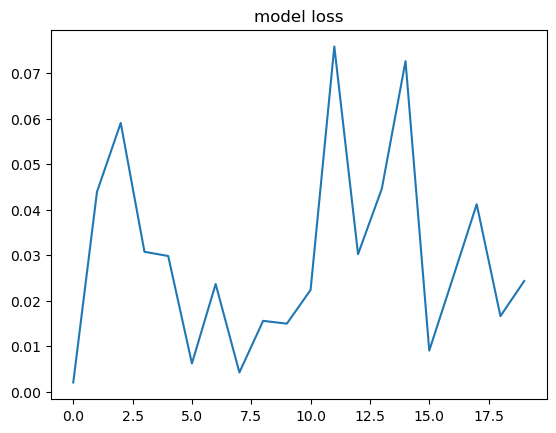

In [28]:
# Visualize the loss evolution during training
plt.plot(losses)
plt.title('model loss')
plt.show()

In [29]:
real, pred = predict_consumption(model_tt,dataloader_test)
real = [v.item() for v in real]
pred = [v.item() for v in pred]
scaler = dataset.column_scalers[dataset.target_labels[0]]
real_sc = dataset.denormalize_values(real,scaler)
pred_sc = dataset.denormalize_values(pred,scaler)

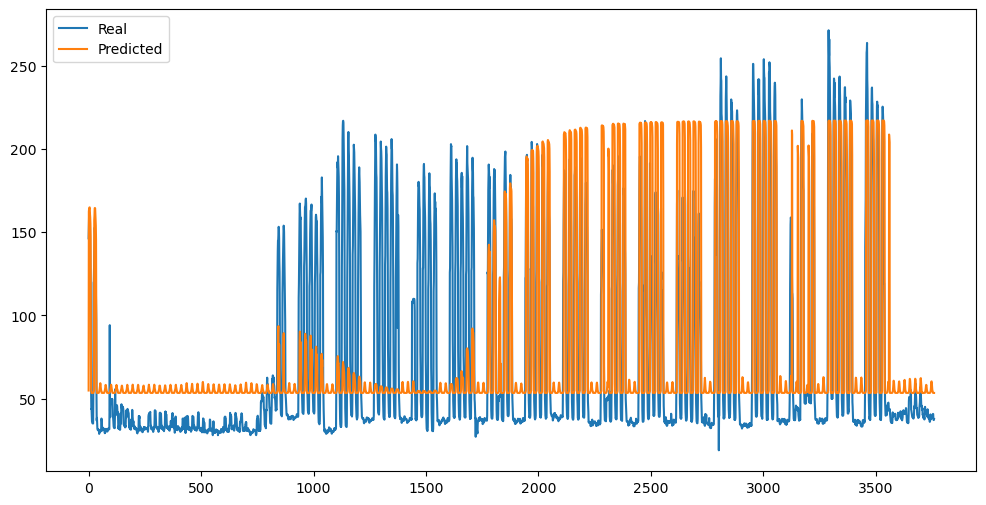

In [30]:
plt.figure(figsize=(12, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(real_sc, label='Real')  # Add a label for the real data
plt.plot(pred_sc, label='Predicted')  # Add a label for the predicted data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

Residual plot:

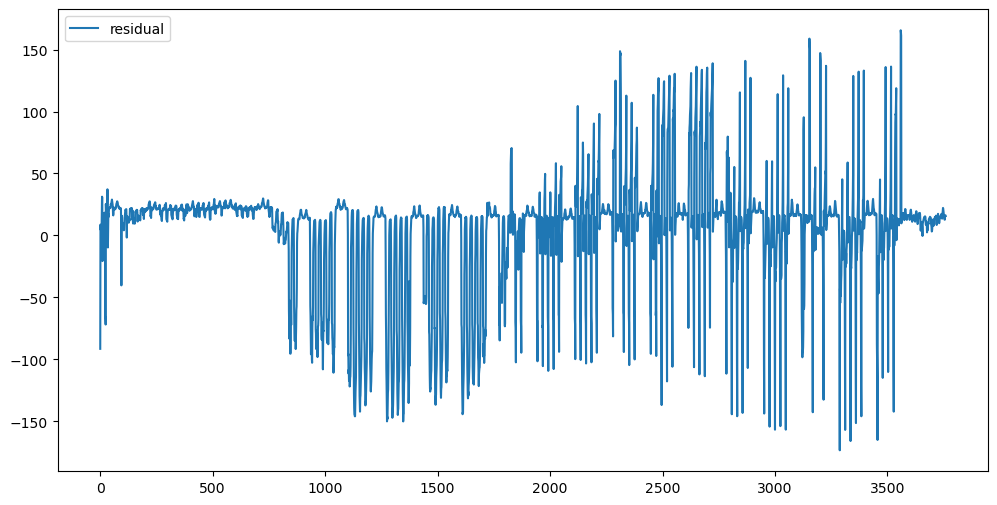

In [31]:
plt.figure(figsize=(12, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(pred_sc-real_sc, label='residual')  # Add a label for the real data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

Not bad, not bad. We see that it is learning some patterns. This is over unseen data

In [32]:
del model_tt

### Is the LSTM + FC part really learning what feature representations mean what or they have learned the sequence over a year?

We'll predict over the same sample all the time

In [33]:
real = []
pred = []
h, c = model.init_hidden(dataloader.batch_size) # Start with a new state in each batch            
h = h.to(device)
c = c.to(device)

#give extra batch dimension to sample
sample = dataset.__getitem__(0)
for i in range(1000):
    with torch.no_grad():
        #current batch size size
        ocu_emb, espai_enc, general_data = sample["ocu_ber_emb"].float().to(device) ,sample["espai_enc"].float().to(device) ,sample["general_data"].float().to(device)
        #give extra batch dimension to sample
        ocu_emb, espai_enc, general_data =   ocu_emb.unsqueeze(0), espai_enc.unsqueeze(0), general_data.unsqueeze(0)
        
        y = sample["y"][0].float().to(device) #we'll do one counter for now
        
        b_sz = ocu_emb.shape[0]
        h, c = model.init_hidden(b_sz) # Start with a new state in each batch            
        h = h.to(device)
        c = c.to(device)

        y_pred, h,c= model(ocu_emb, espai_enc, general_data, h, c)
        pred += list(y_pred[:,0,0].to("cpu"))
        real += [y.to("cpu")]

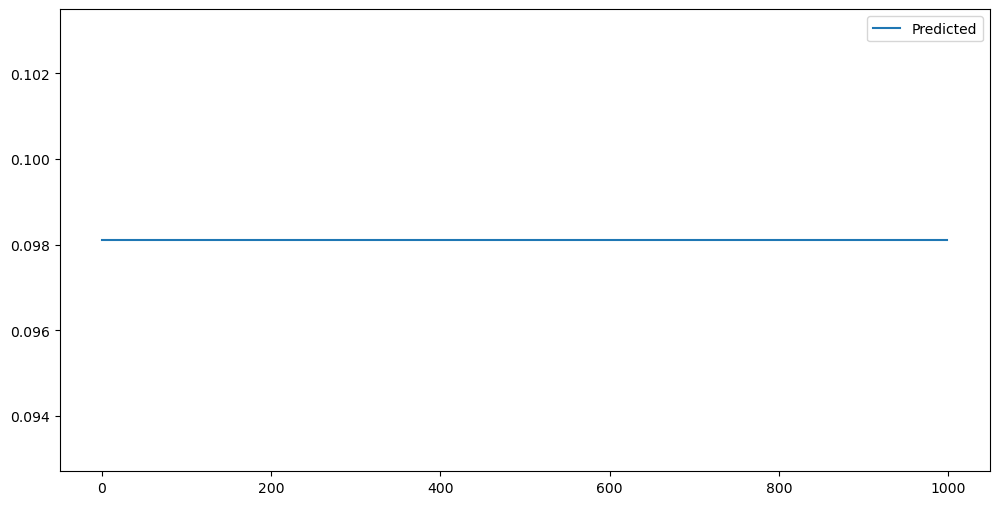

In [34]:
plt.figure(figsize=(12, 6))  # Increase the figure size to make it larger in the x-axis

#plt.plot(real, label='Real')  # Add a label for the real data
plt.plot(pred, label='Predicted')  # Add a label for the predicted data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

With a constant sample predicted a line, which is suggest that the encoding of activities, climate data and time are being learnt and have some impact.

## Solving the value clipping problem:

Hypotheses: Maybe the Relu is clipping the negative values so its hard for the network to create jumps in value under the bias. Or something like that. Change ReLu in the regressor FC to leaky relu

In [62]:
class attentive_model_pepemarti(nn.Module):
    def __init__(self, espai_emb_dim,hidden_dim,lstm_nl,target_dim):
        super(attentive_model_pepemarti, self).__init__()
        self.espai_emb_dim = espai_emb_dim
        self.hidden_dim = hidden_dim
        self.lstm_nl = lstm_nl

        self.espai_emb = nn.Embedding(num_embeddings=len(dataset.espais_vocab),embedding_dim=espai_emb_dim)
        self.classe_repr = nn.Sequential(
            nn.Linear(in_features=BERT_DIM_EMB+espai_emb_dim,out_features=601),
            nn.ReLU(),
            nn.Linear(in_features=601,out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256,out_features=51),
            nn.ReLU(),
            nn.Linear(in_features=51,out_features=TIME_CLIMATE_DIM),
            nn.Softmax(dim=-1)
        )

        self.key_gen =  nn.Sequential(
            nn.Linear(in_features=TIME_CLIMATE_DIM,out_features=40),
            nn.ReLU(),
            nn.Linear(in_features=40,out_features=hidden_dim),
            nn.Softmax(dim=-1)
        )

        self.val_gen =  nn.Sequential(
            nn.Linear(in_features=TIME_CLIMATE_DIM,out_features=40),
            nn.ReLU(),
            nn.Linear(in_features=40,out_features=hidden_dim),
            nn.ReLU(),
        )

        self.query_gen =  nn.Sequential(
            nn.Linear(in_features=TIME_CLIMATE_DIM,out_features=40),
            nn.ReLU(),
            nn.Linear(in_features=40,out_features=hidden_dim),
            nn.Softmax(dim=-1)
        )
        
        self.multihead_attn = nn.MultiheadAttention(hidden_dim,3,batch_first=True)
        
        self.lstm = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=self.lstm_nl, dropout=0, batch_first=True) #input -> BATCH, SEQ_LENGHT, EMBEDDING_DIM
        
        self.regressFC = nn.Linear(in_features=self.hidden_dim,out_features=1)

    def forward(self,ocu_ber_emb,espai_enc,general_data,h,c):
        #embedd the espais
        espai_emb = self.espai_emb(espai_enc.to(torch.int)).float()
        #concatenate activity and espai vector
        act_cat_espai = torch.cat((ocu_ber_emb,espai_emb),axis=2)

        #pass act_cat_espai through a FC to have a "classe" representation
        classe_repr = self.classe_repr(act_cat_espai.float())
    
        #get this representation and multiply it with the general data "sort of attention here"
        #first extend the general data so we have a pair for each class vector
        general_rep = general_data.unsqueeze(1).repeat(1, 34, 1)
        general_at_per_class = general_rep * classe_repr #element wise multiplication
        general_at_per_class = general_at_per_class.float() #convert to float32

        key = self.key_gen(general_at_per_class) #generate key with FC
        value = self.val_gen(general_at_per_class) #generate value with FC
        query = self.query_gen(general_at_per_class) #generate query with FC
        
        #att_mask = torch.sum(ocu_ber_emb,axis=2) != 0.0 #look for what values have to enter. The ones that aren't padding
        #att_mask = att_mask.unsqueeze(1)
        #att_mask = att_mask.repeat(3, att_mask.shape[2], 1)#repeat 3 times along batch dim because we have three heads. The other repeat is because we need it to be of shape seqlenxseqlen 
        #output, _ =  self.multihead_attn(key=key, value=value, query=query,attn_mask=att_mask)
        output, _ =  self.multihead_attn(key=key, value=value, query=query)
        output = torch.sum(output,axis=1)

        #create extra to output be a sequence of 1
        output = output.unsqueeze(1)
        
        #pass this as the inital state to a LSTM
        out, (h,c) = self.lstm(output, (h,c))
        out =  self.regressFC(out).float()
        #ic(out.shape)
        return out, h, c
    
    def init_hidden(self,batch_size):
        # Initialize the hidden state and cell state with zeros
        h = torch.zeros(self.lstm_nl, batch_size, self.hidden_dim,dtype=torch.float32)
        c = torch.zeros(self.lstm_nl, batch_size, self.hidden_dim,dtype=torch.float32)
        return h, c

    def init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)
    

Train again:

In [63]:
del model

In [64]:
model = attentive_model_pepemarti(espai_emb_dim=30,hidden_dim=30,lstm_nl=1,target_dim=1)

In [65]:
model.init_weights()
model = model.to(device)

In [66]:
#now you can create a dataloader and use it!
batch_size = 100
dataloader = DataLoader(dataset, batch_size, shuffle=False)

In [67]:
num_epochs = 20
losses = train(dataloader, model, batch_size=100, num_epochs=num_epochs)

{'epoch': 0, 'batch': 0, 'loss': 0.01222065556794405}
{'epoch': 0, 'batch': 30, 'loss': 0.012230508029460907}
{'epoch': 0, 'batch': 60, 'loss': 0.048876676708459854}
{'epoch': 1, 'batch': 0, 'loss': 0.029377179220318794}
{'epoch': 1, 'batch': 30, 'loss': 0.010583077557384968}
{'epoch': 1, 'batch': 60, 'loss': 0.03692203015089035}
{'epoch': 2, 'batch': 0, 'loss': 0.018124984577298164}
{'epoch': 2, 'batch': 30, 'loss': 0.0112025560811162}
{'epoch': 2, 'batch': 60, 'loss': 0.02528919093310833}
{'epoch': 3, 'batch': 0, 'loss': 0.016070498153567314}
{'epoch': 3, 'batch': 30, 'loss': 0.011429520323872566}
{'epoch': 3, 'batch': 60, 'loss': 0.014955448918044567}
{'epoch': 4, 'batch': 0, 'loss': 0.018949933350086212}
{'epoch': 4, 'batch': 30, 'loss': 0.012865706346929073}
{'epoch': 4, 'batch': 60, 'loss': 0.014090287499129772}
{'epoch': 5, 'batch': 0, 'loss': 0.015594616532325745}
{'epoch': 5, 'batch': 30, 'loss': 0.013268168084323406}
{'epoch': 5, 'batch': 60, 'loss': 0.012521476484835148}
{'e

In [45]:
torch.save(model, "models/attention_exp_LSTM/model2.pth")

In [46]:
model = torch.load( "models/attention_exp_LSTM/model2.pth")

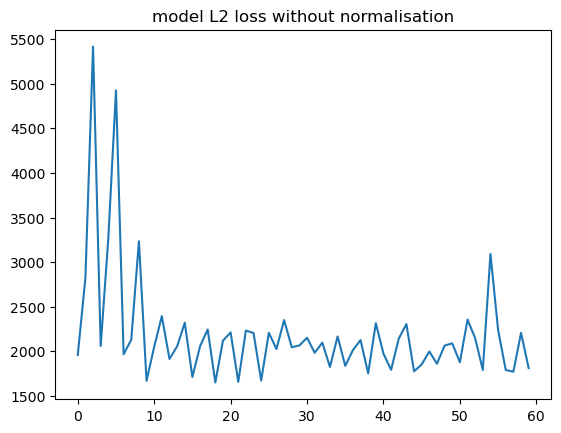

In [57]:
scaler = dataset.column_scalers[dataset.target_labels[0]]
#get the simple loss back from the squared error
scaled_losses = np.ravel(np.power(dataset.denormalize_values(np.sqrt(losses),scaler),2))
plt.plot(scaled_losses)
plt.title('model L2 loss without normalisation')
plt.show()

In [58]:
#now you can create a dataloader and use it!
dataloader = DataLoader(dataset, len(dataset), shuffle=False)

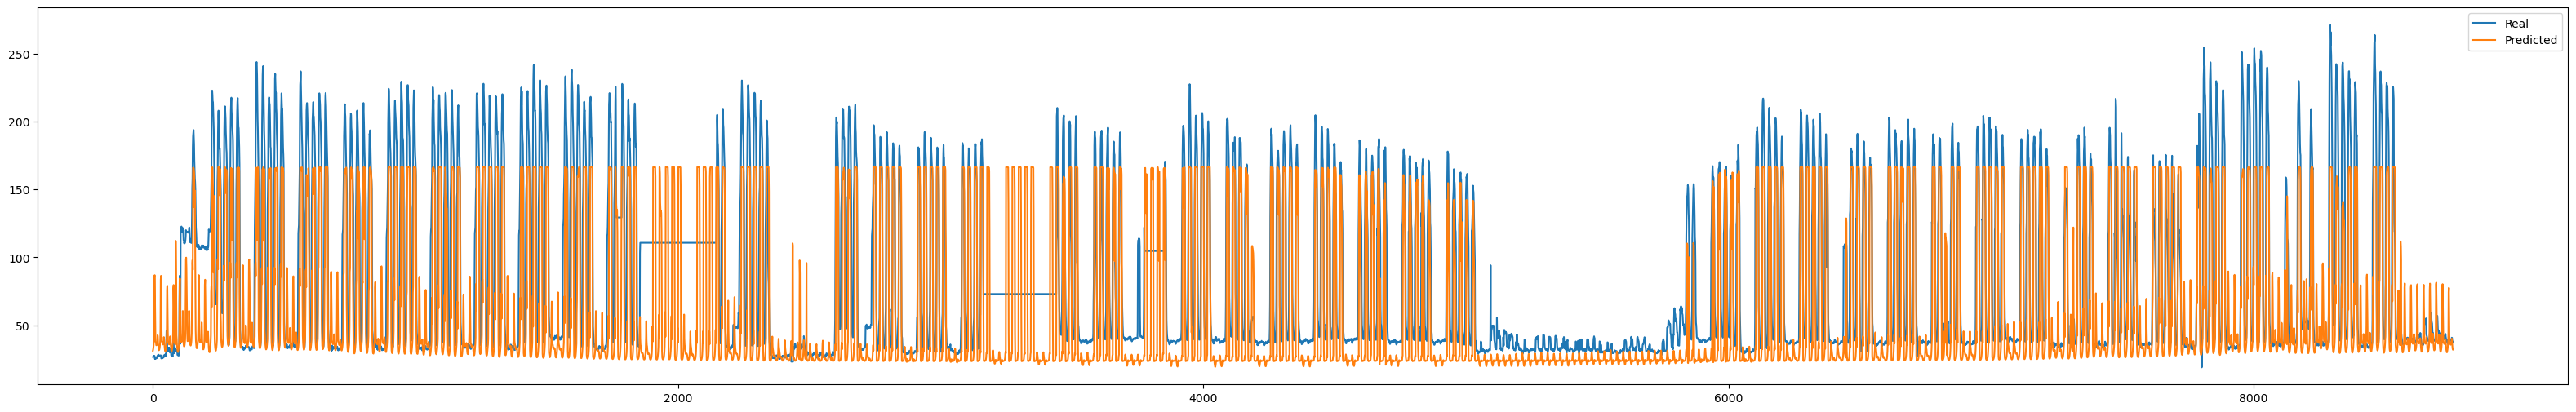

In [68]:
real, pred = predict_consumption(model,dataloader)
real = [v.item() for v in real]
pred = [v.item() for v in pred]
scaler = dataset.column_scalers[dataset.target_labels[0]]
real_sc = dataset.denormalize_values(real,scaler)
pred_sc = dataset.denormalize_values(pred,scaler)
plt.figure(figsize=(40, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(real_sc, label='Real')  # Add a label for the real data
plt.plot(pred_sc, label='Predicted')  # Add a label for the predicted data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

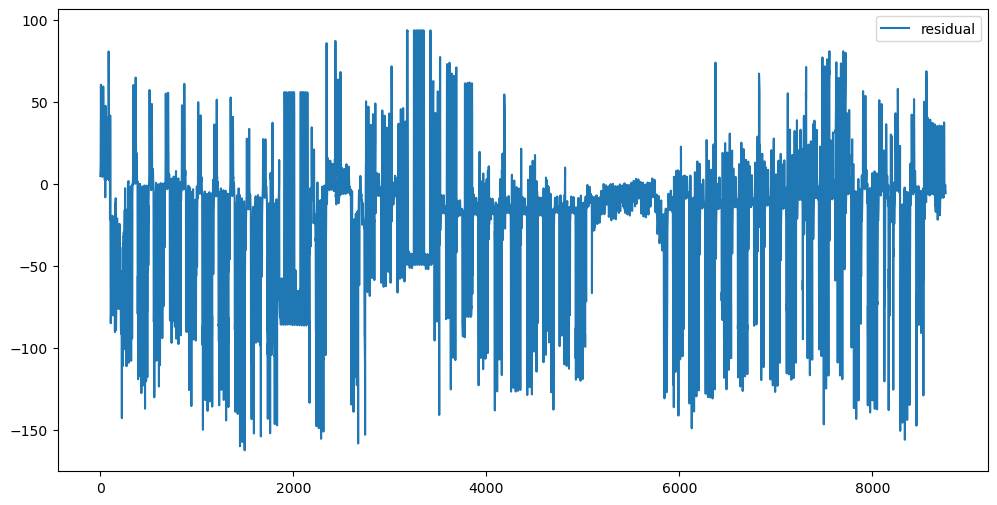

In [69]:
plt.figure(figsize=(12, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(pred_sc-real_sc, label='residual')  # Add a label for the real data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

### Trying to simplify

Things changed: Removed squeeze attention and fed to attention the espai embedding directly as a key, activ -> FC as query , repeated climate data -> FC as values. Added the resulting vectors and directly to a linear layer for regresion.

In [77]:
class attentive_model_pepemarti(nn.Module):
    def __init__(self, espai_emb_dim,hidden_dim,lstm_nl,target_dim):
        super(attentive_model_pepemarti, self).__init__()
        self.espai_emb_dim = espai_emb_dim
        self.hidden_dim = hidden_dim
        self.lstm_nl = lstm_nl

        self.espai_emb = nn.Embedding(num_embeddings=len(dataset.espais_vocab),embedding_dim=espai_emb_dim)
        self.classe_repr = nn.Sequential(
            nn.Linear(in_features=BERT_DIM_EMB+espai_emb_dim,out_features=601),
            nn.ReLU(),
            nn.Linear(in_features=601,out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256,out_features=51),
            nn.ReLU(),
            nn.Linear(in_features=51,out_features=TIME_CLIMATE_DIM),
            nn.Softmax(dim=-1)
        )

        self.val_gen =  nn.Sequential(
            nn.Linear(in_features=TIME_CLIMATE_DIM,out_features=40),
            nn.ReLU(),
            nn.Linear(in_features=40,out_features=hidden_dim),
            nn.ReLU(),
        )

        self.query_gen =  nn.Sequential(
            nn.Linear(in_features=BERT_DIM_EMB,out_features=40),
            nn.ReLU(),
            nn.Linear(in_features=40,out_features=hidden_dim),
            nn.Softmax(dim=-1)
        )
        
        self.multihead_attn = nn.MultiheadAttention(hidden_dim,3,batch_first=True)
        
        self.lstm = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=self.lstm_nl, dropout=0, batch_first=True) #input -> BATCH, SEQ_LENGHT, EMBEDDING_DIM
        
        self.regressFC = nn.Linear(in_features=hidden_dim,out_features=1)

    def forward(self,ocu_ber_emb,espai_enc,general_data,h,c):
        #embedd the espais
        espai_emb = self.espai_emb(espai_enc.to(torch.int)).float()
    
        #first extend the general data so we have a pair for each class vector
        general_rep = general_data.unsqueeze(1).repeat(1, 34, 1)

        #key = self.key_gen(espai_emb) #generate key with FC key is directly the embedding
        value = self.val_gen(general_rep) #generate value with FC
        query = self.query_gen(ocu_ber_emb) #generate query with FC
        
        #att_mask = torch.sum(ocu_ber_emb,axis=2) != 0.0 #look for what values have to enter. The ones that aren't padding
        #att_mask = att_mask.unsqueeze(1)
        #att_mask = att_mask.repeat(3, att_mask.shape[2], 1)#repeat 3 times along batch dim because we have three heads. The other repeat is because we need it to be of shape seqlenxseqlen 
        #output, _ =  self.multihead_attn(key=key, value=value, query=query,attn_mask=att_mask)
        output, _ =  self.multihead_attn(key=espai_emb, value=value, query=query)
        output = torch.sum(output,axis=1)

        #create extra to output be a sequence of 1
        #output = output.unsqueeze(1)
        
        #pass this as the inital state to a LSTM
        #out, (h,c) = self.lstm(output, (h,c))
        #ic(general_at_per_class.shape)
        #out = torch.reshape(output,(output.shape[0],output.shape[1]*output.shape[2]))
        #ic(out.shape)
        out =  self.regressFC(output).float()
        out = out.unsqueeze(1) #extra dim to reuse train and predict function
        return out, h, c
    
    def init_hidden(self,batch_size):
        # Initialize the hidden state and cell state with zeros
        h = torch.zeros(self.lstm_nl, batch_size, self.hidden_dim,dtype=torch.float32)
        c = torch.zeros(self.lstm_nl, batch_size, self.hidden_dim,dtype=torch.float32)
        return h, c

    def init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

In [78]:
del model

In [79]:
model = attentive_model_pepemarti(espai_emb_dim=30,hidden_dim=30,lstm_nl=1,target_dim=1)

In [80]:
model.init_weights()
model = model.to(device)

In [81]:
#now you can create a dataloader and use it!
batch_size = 100
dataloader = DataLoader(dataset, batch_size, shuffle=False)

In [82]:
num_epochs = 20
losses = train(dataloader, model, batch_size=100, num_epochs=num_epochs)

{'epoch': 0, 'batch': 0, 'loss': 238.7147979736328}
{'epoch': 0, 'batch': 30, 'loss': 2.3881776332855225}
{'epoch': 0, 'batch': 60, 'loss': 0.6245896816253662}
{'epoch': 1, 'batch': 0, 'loss': 1.0314178466796875}
{'epoch': 1, 'batch': 30, 'loss': 0.6211588978767395}
{'epoch': 1, 'batch': 60, 'loss': 0.4756023585796356}
{'epoch': 2, 'batch': 0, 'loss': 0.9038734436035156}
{'epoch': 2, 'batch': 30, 'loss': 0.34013888239860535}
{'epoch': 2, 'batch': 60, 'loss': 0.4870738089084625}
{'epoch': 3, 'batch': 0, 'loss': 0.5968427658081055}
{'epoch': 3, 'batch': 30, 'loss': 0.37291038036346436}
{'epoch': 3, 'batch': 60, 'loss': 0.358764111995697}
{'epoch': 4, 'batch': 0, 'loss': 0.37879064679145813}
{'epoch': 4, 'batch': 30, 'loss': 0.4588121771812439}
{'epoch': 4, 'batch': 60, 'loss': 0.20276179909706116}
{'epoch': 5, 'batch': 0, 'loss': 0.5585442781448364}
{'epoch': 5, 'batch': 30, 'loss': 0.3351294994354248}
{'epoch': 5, 'batch': 60, 'loss': 0.3449136018753052}
{'epoch': 6, 'batch': 0, 'loss':

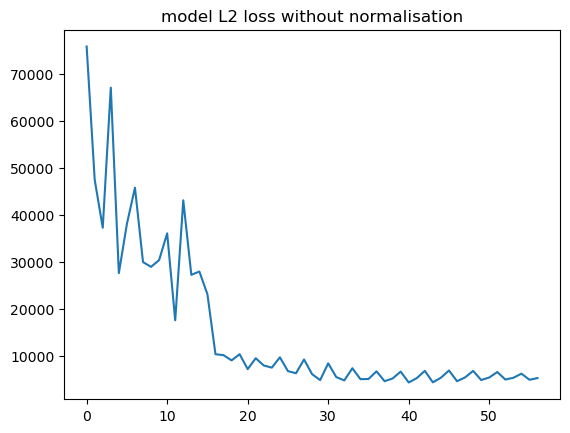

In [88]:
import matplotlib.pyplot as plt
scaler = dataset.column_scalers[dataset.target_labels[0]]
#get the simple loss back from the squared error
scaled_losses = np.ravel(np.power(dataset.denormalize_values(np.sqrt(losses),scaler),2))
plt.plot(scaled_losses[3:])
plt.title('model L2 loss without normalisation')
plt.show()

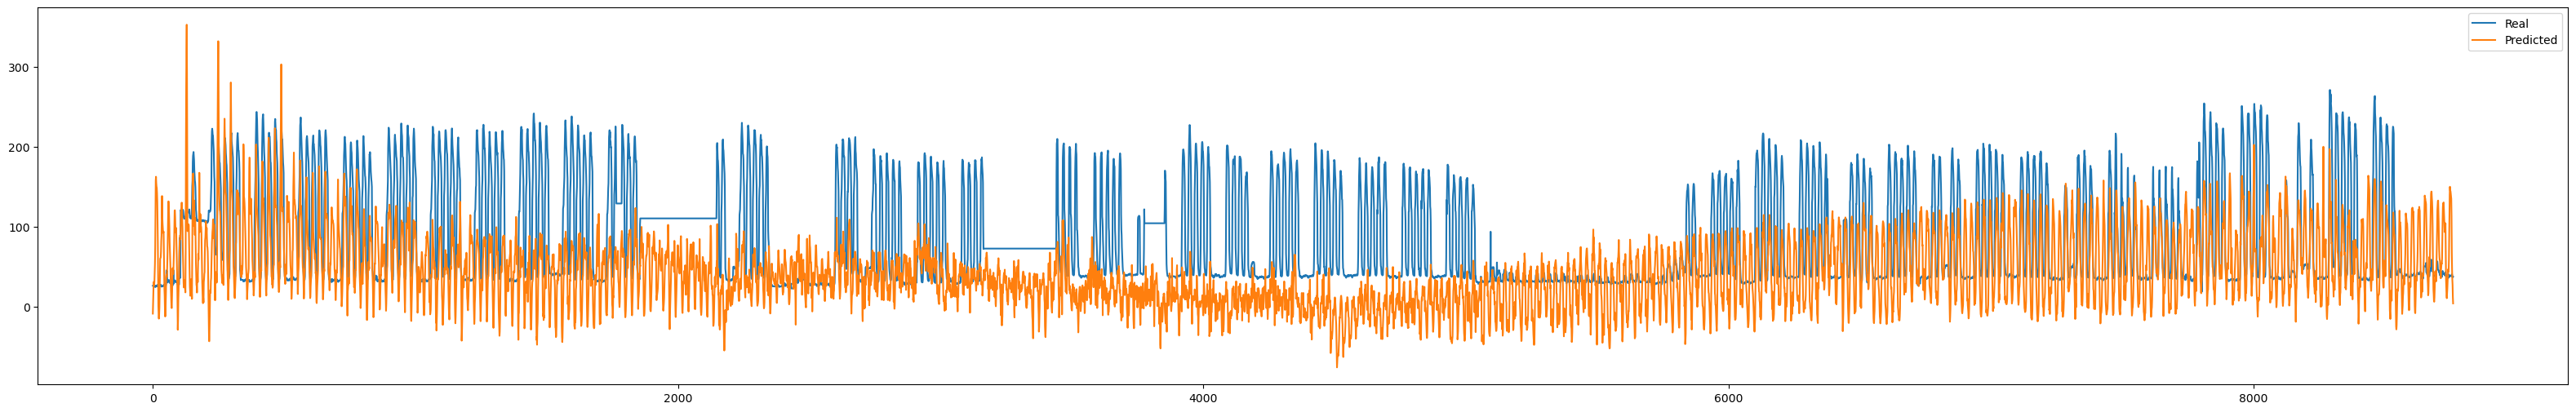

In [85]:
real, pred = predict_consumption(model,dataloader)
real = [v.item() for v in real]
pred = [v.item() for v in pred]
scaler = dataset.column_scalers[dataset.target_labels[0]]
real_sc = dataset.denormalize_values(real,scaler)
pred_sc = dataset.denormalize_values(pred,scaler)
plt.figure(figsize=(40, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(real_sc, label='Real')  # Add a label for the real data
plt.plot(pred_sc, label='Predicted')  # Add a label for the predicted data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

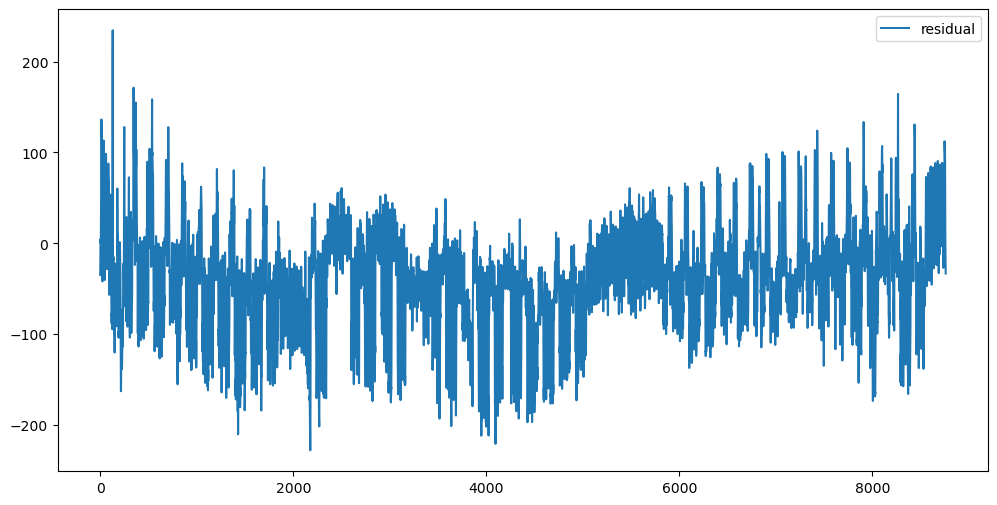

In [89]:
plt.figure(figsize=(12, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(pred_sc-real_sc, label='residual')  # Add a label for the real data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

Now instead of passing the current value to the linear layer first go through the LSTM

In [ ]:
class attentive_model_pepemarti(nn.Module):
    def __init__(self, espai_emb_dim,hidden_dim,lstm_nl,target_dim):
        super(attentive_model_pepemarti, self).__init__()
        self.espai_emb_dim = espai_emb_dim
        self.hidden_dim = hidden_dim
        self.lstm_nl = lstm_nl

        self.espai_emb = nn.Embedding(num_embeddings=len(dataset.espais_vocab),embedding_dim=espai_emb_dim)
        self.classe_repr = nn.Sequential(
            nn.Linear(in_features=BERT_DIM_EMB+espai_emb_dim,out_features=601),
            nn.ReLU(),
            nn.Linear(in_features=601,out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256,out_features=51),
            nn.ReLU(),
            nn.Linear(in_features=51,out_features=TIME_CLIMATE_DIM),
            nn.Softmax(dim=-1)
        )

        self.val_gen =  nn.Sequential(
            nn.Linear(in_features=TIME_CLIMATE_DIM,out_features=40),
            nn.ReLU(),
            nn.Linear(in_features=40,out_features=hidden_dim),
            nn.ReLU(),
        )

        self.query_gen =  nn.Sequential(
            nn.Linear(in_features=BERT_DIM_EMB,out_features=40),
            nn.ReLU(),
            nn.Linear(in_features=40,out_features=hidden_dim),
            nn.Softmax(dim=-1)
        )
        
        self.multihead_attn = nn.MultiheadAttention(hidden_dim,3,batch_first=True)
        
        self.lstm = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=self.lstm_nl, dropout=0, batch_first=True) #input -> BATCH, SEQ_LENGHT, EMBEDDING_DIM
        
        self.regressFC = nn.Linear(in_features=hidden_dim,out_features=1)

    def forward(self,ocu_ber_emb,espai_enc,general_data,h,c):
        #embedd the espais
        espai_emb = self.espai_emb(espai_enc.to(torch.int)).float()
    
        #first extend the general data so we have a pair for each class vector
        general_rep = general_data.unsqueeze(1).repeat(1, 34, 1)

        #key = self.key_gen(espai_emb) #generate key with FC key is directly the embedding
        value = self.val_gen(general_rep) #generate value with FC
        query = self.query_gen(ocu_ber_emb) #generate query with FC
        
        #att_mask = torch.sum(ocu_ber_emb,axis=2) != 0.0 #look for what values have to enter. The ones that aren't padding
        #att_mask = att_mask.unsqueeze(1)
        #att_mask = att_mask.repeat(3, att_mask.shape[2], 1)#repeat 3 times along batch dim because we have three heads. The other repeat is because we need it to be of shape seqlenxseqlen 
        #output, _ =  self.multihead_attn(key=key, value=value, query=query,attn_mask=att_mask)
        output, _ =  self.multihead_attn(key=espai_emb, value=value, query=query)
        output = torch.sum(output,axis=1)

        #create extra to output be a sequence of 1
        output = output.unsqueeze(1)
        
        #pass this as the inital state to a LSTM
        out, (h,c) = self.lstm(output, (h,c))
        out =  self.regressFC(output).float()
        out = out.unsqueeze(1) #extra dim to reuse train and predict function
        return out, h, c
    
    def init_hidden(self,batch_size):
        # Initialize the hidden state and cell state with zeros
        h = torch.zeros(self.lstm_nl, batch_size, self.hidden_dim,dtype=torch.float32)
        c = torch.zeros(self.lstm_nl, batch_size, self.hidden_dim,dtype=torch.float32)
        return h, c

    def init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

In [90]:
del model

In [91]:
model = attentive_model_pepemarti(espai_emb_dim=30,hidden_dim=30,lstm_nl=1,target_dim=1)

In [94]:
model.init_weights()
model = model.to(device)

In [92]:
#now you can create a dataloader and use it!
batch_size = 100
dataloader = DataLoader(dataset, batch_size, shuffle=False)

In [92]:
num_epochs = 20
losses = train(dataloader, model, batch_size=100, num_epochs=num_epochs)

{'epoch': 0, 'batch': 0, 'loss': 0.01667696237564087}
{'epoch': 0, 'batch': 30, 'loss': 0.028113894164562225}
{'epoch': 0, 'batch': 60, 'loss': 0.0129264360293746}
{'epoch': 1, 'batch': 0, 'loss': 0.008039755746722221}
{'epoch': 1, 'batch': 30, 'loss': 0.006288573611527681}
{'epoch': 1, 'batch': 60, 'loss': 0.012308672070503235}
{'epoch': 2, 'batch': 0, 'loss': 0.018326567485928535}
{'epoch': 2, 'batch': 30, 'loss': 0.006767524406313896}
{'epoch': 2, 'batch': 60, 'loss': 0.014555507339537144}
{'epoch': 3, 'batch': 0, 'loss': 0.008718782104551792}
{'epoch': 3, 'batch': 30, 'loss': 0.0527314618229866}
{'epoch': 3, 'batch': 60, 'loss': 0.013621894642710686}
{'epoch': 4, 'batch': 0, 'loss': 0.011973831802606583}
{'epoch': 4, 'batch': 30, 'loss': 0.02489996887743473}
{'epoch': 4, 'batch': 60, 'loss': 0.011552526615560055}
{'epoch': 5, 'batch': 0, 'loss': 0.01723504438996315}
{'epoch': 5, 'batch': 30, 'loss': 0.02188967913389206}
{'epoch': 5, 'batch': 60, 'loss': 0.010229614563286304}
{'epoc

KeyboardInterrupt: 

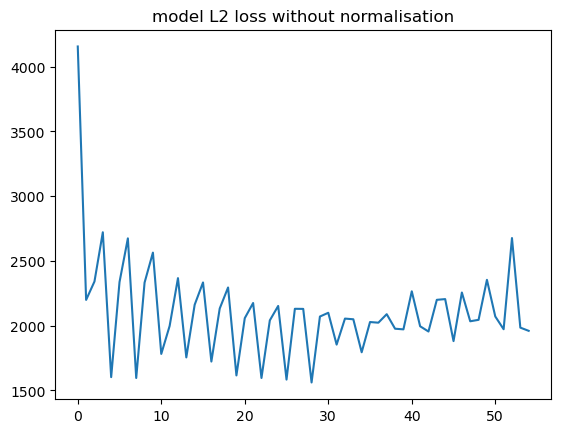

In [ ]:
import matplotlib.pyplot as plt
scaler = dataset.column_scalers[dataset.target_labels[0]]
#get the simple loss back from the squared error
scaled_losses = np.ravel(np.power(dataset.denormalize_values(np.sqrt(losses),scaler),2))
plt.plot(scaled_losses)
plt.title('model L2 loss without normalisation')
plt.show()

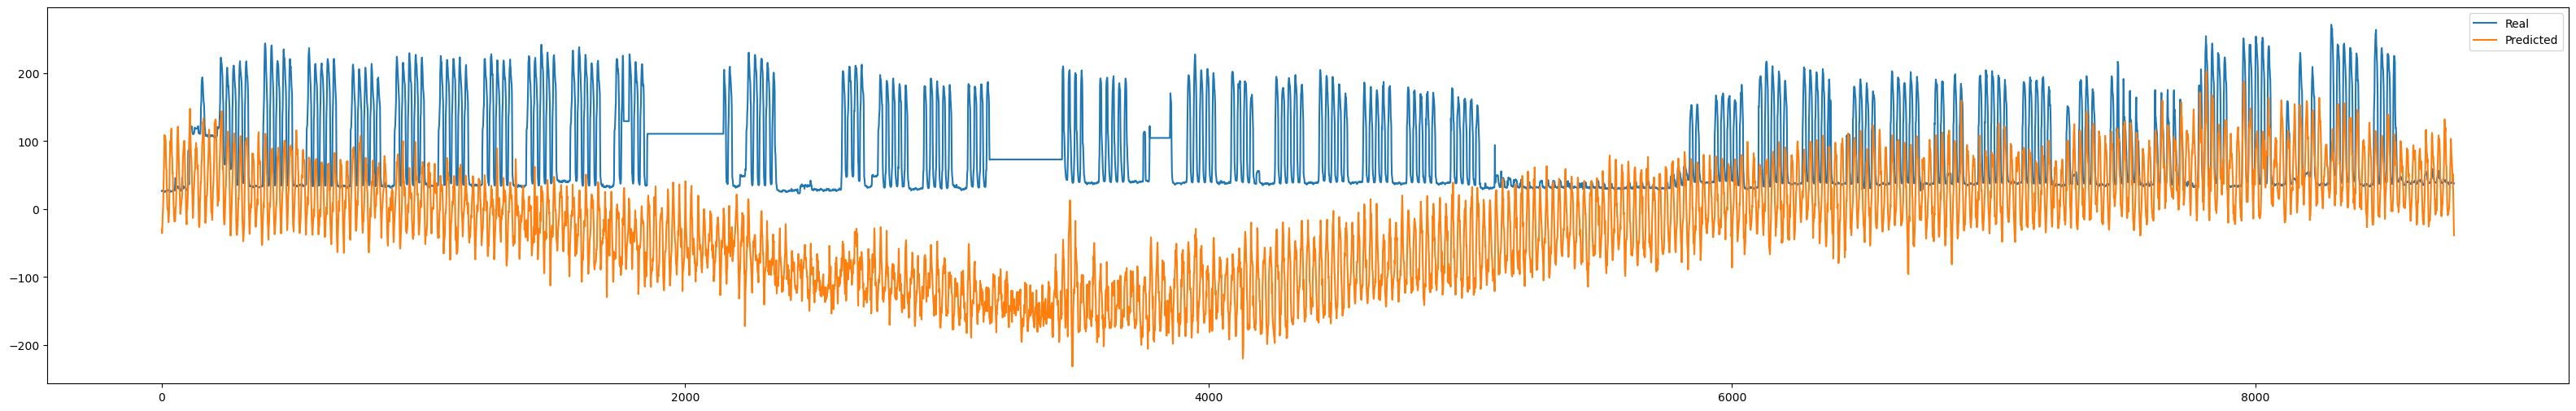

In [97]:
real, pred = predict_consumption(model,dataloader)
real = [v.item() for v in real]
pred = [v.item() for v in pred]
scaler = dataset.column_scalers[dataset.target_labels[0]]
real_sc = dataset.denormalize_values(real,scaler)
pred_sc = dataset.denormalize_values(pred,scaler)
plt.figure(figsize=(40, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(real_sc, label='Real')  # Add a label for the real data
plt.plot(pred_sc, label='Predicted')  # Add a label for the predicted data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

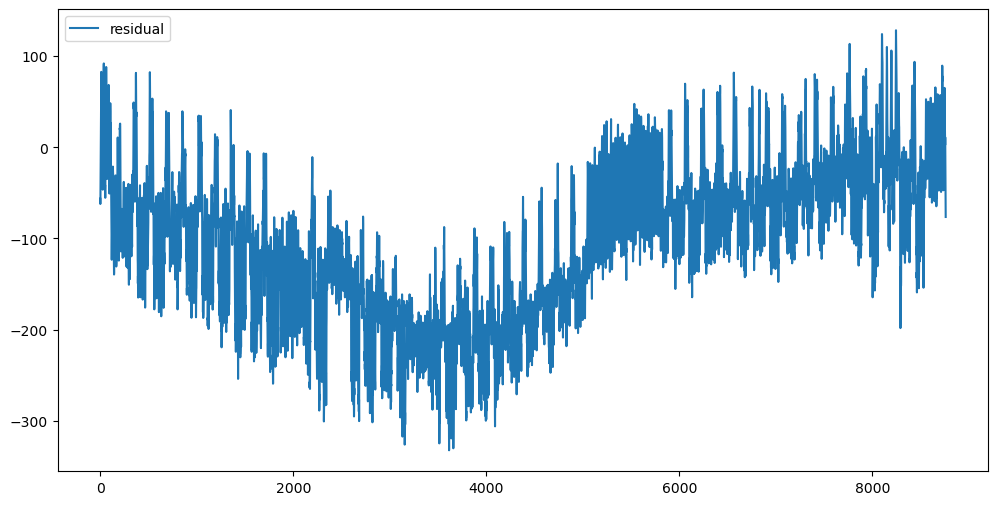

In [98]:
plt.figure(figsize=(12, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(pred_sc-real_sc, label='residual')  # Add a label for the real data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

We can conclude that the gating thing is doing something. So we'll keep it. But in the end it was the same of what we have implemented now right? an attention layer.
We'll try layering those creating in essence a transformer.

Maybe set them up in a way we can process a whole batch in one go?

## Transformer + LSTM setup

In [14]:
class AttentionBlock(nn.Module):
    def __init__(self, key_dim, val_dim, query_dim, hidden_dim, num_heads,FC_hidden=80):
        super(AttentionBlock, self).__init__()
        self.key_gen = nn.Sequential(
            nn.Linear(key_dim, 80),
            nn.ReLU(),
            nn.Linear(80, 80),
            nn.ReLU(),
            nn.Linear(80, hidden_dim),
            nn.ReLU(),
        )

        self.val_gen = nn.Sequential(
            nn.Linear(val_dim, 80),
            nn.ReLU(),
            nn.Linear(80, 80),
            nn.ReLU(),
            nn.Linear(80, hidden_dim),
            nn.ReLU(),
        )
        
        self.query_gen = nn.Sequential(
            nn.Linear(query_dim, 80),
            nn.ReLU(),
            nn.Linear(80, 80),
            nn.ReLU(),
            nn.Linear(80, hidden_dim),
            nn.Softmax(dim=-1),
        )
        self.multihead_attn = nn.MultiheadAttention(hidden_dim, num_heads, batch_first=True)
    
    def forward(self,keys,values,queries):
        key = self.key_gen(keys) #generate key with FC key is directly the embedding
        value = self.val_gen(values) #generate value with FC
        query = self.query_gen(queries) #generate query with FC
        output, _ =  self.multihead_attn(key=key, value=value, query=query)
        return output
        

In [15]:
class attentive_model_pepemarti(nn.Module):
    def __init__(self, espai_emb_dim,hidden_dim,lstm_nl,target_dim,nheads):
        super(attentive_model_pepemarti, self).__init__()
        self.espai_emb_dim = espai_emb_dim
        self.hidden_dim = hidden_dim
        self.lstm_nl = lstm_nl
        self.nheads = nheads

        self.espai_emb = nn.Embedding(num_embeddings=len(dataset.espais_vocab),embedding_dim=espai_emb_dim)

        self.selfattn1 =  AttentionBlock(key_dim=espai_emb_dim, val_dim=espai_emb_dim, query_dim=espai_emb_dim, hidden_dim=hidden_dim, num_heads=nheads)
        self.selfattn2 =  AttentionBlock(key_dim=TIME_CLIMATE_DIM, val_dim=TIME_CLIMATE_DIM, query_dim=TIME_CLIMATE_DIM, hidden_dim=hidden_dim, num_heads=nheads)
        self.selfattn3 =  AttentionBlock(key_dim=BERT_DIM_EMB, val_dim=BERT_DIM_EMB, query_dim=BERT_DIM_EMB, hidden_dim=hidden_dim, num_heads=nheads)
        
        self.gatingFC_ocu = nn.Sequential(
            nn.Linear(hidden_dim, 80),
            nn.ReLU(),
            nn.Linear(80, 80),
            nn.ReLU(),
            nn.Linear(80, hidden_dim),
            nn.Softmax(dim=-1),
        )

        self.gatingFC_esp = nn.Sequential(
            nn.Linear(hidden_dim, 80),
            nn.ReLU(),
            nn.Linear(80, 80),
            nn.ReLU(),
            nn.Linear(80, hidden_dim),
            nn.Softmax(dim=-1),
        )
        
        self.lstm = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=self.lstm_nl, dropout=0, batch_first=True) #input -> BATCH, SEQ_LENGHT, EMBEDDING_DIM
        
        self.regressFC = nn.Linear(in_features=hidden_dim,out_features=1)

    def forward(self,ocu_ber_emb,espai_enc,general_data,h,c):
        #embedd the espais
        espai_emb = self.espai_emb(espai_enc.to(torch.int)).float()

        #first extend the general data so we have a pair for each class vector
        general_rep = general_data.unsqueeze(1).repeat(1, 34, 1)

        queries = self.selfattn3(ocu_ber_emb,ocu_ber_emb,ocu_ber_emb)
        values = self.selfattn2(general_rep,general_rep,general_rep)
        keys = self.selfattn1(espai_emb,espai_emb,espai_emb)
        
        out = keys + values + queries #+ out

        out1 = out * self.gatingFC_ocu(queries)
        out2 = out * self.gatingFC_esp(keys)

        out = out1 + out2

        out = torch.sum(out,axis=1)

        #create extra to output be a sequence of 1
        out = out.unsqueeze(1)
        
        #pass this as the inital state to a LSTM
        out, (h,c) = self.lstm(out, (h,c))
        out =  self.regressFC(out).float()
        #out = out.unsqueeze(1) #extra dim to reuse train and predict function
        return out, h, c
    
    def init_hidden(self,batch_size):
        # Initialize the hidden state and cell state with zeros
        h = torch.zeros(self.lstm_nl, batch_size, self.hidden_dim,dtype=torch.float32)
        c = torch.zeros(self.lstm_nl, batch_size, self.hidden_dim,dtype=torch.float32)
        return h, c

    def init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

In [168]:
del model

In [16]:
model = attentive_model_pepemarti(espai_emb_dim=30,hidden_dim=30,lstm_nl=1,target_dim=1,nheads=3)

In [17]:
model.init_weights()
model = model.to(device)

In [18]:
#now you can create a dataloader and use it!
batch_size = 100
dataloader = DataLoader(dataset, batch_size, shuffle=False)

In [19]:
num_epochs = 20
losses = train(dataloader, model, batch_size=100, num_epochs=num_epochs,lr=0.0001,y_idx=2)

{'epoch': 0, 'batch': 0, 'loss': 0.06438646465539932}
{'epoch': 0, 'batch': 30, 'loss': 0.002638409147039056}
{'epoch': 0, 'batch': 60, 'loss': 0.015168153680860996}
{'epoch': 1, 'batch': 0, 'loss': 0.00047625595470890403}
{'epoch': 1, 'batch': 30, 'loss': 0.001628149882890284}
{'epoch': 1, 'batch': 60, 'loss': 0.013239347375929356}
{'epoch': 2, 'batch': 0, 'loss': 0.0008777159382589161}
{'epoch': 2, 'batch': 30, 'loss': 0.0020209625363349915}
{'epoch': 2, 'batch': 60, 'loss': 0.011184195056557655}
{'epoch': 3, 'batch': 0, 'loss': 0.001795803545974195}
{'epoch': 3, 'batch': 30, 'loss': 0.0024755029007792473}
{'epoch': 3, 'batch': 60, 'loss': 0.009316508658230305}
{'epoch': 4, 'batch': 0, 'loss': 0.0030213799327611923}
{'epoch': 4, 'batch': 30, 'loss': 0.003864291124045849}
{'epoch': 4, 'batch': 60, 'loss': 0.009067458100616932}
{'epoch': 5, 'batch': 0, 'loss': 0.0041664969176054}
{'epoch': 5, 'batch': 30, 'loss': 0.005445096176117659}
{'epoch': 5, 'batch': 60, 'loss': 0.010273613967001

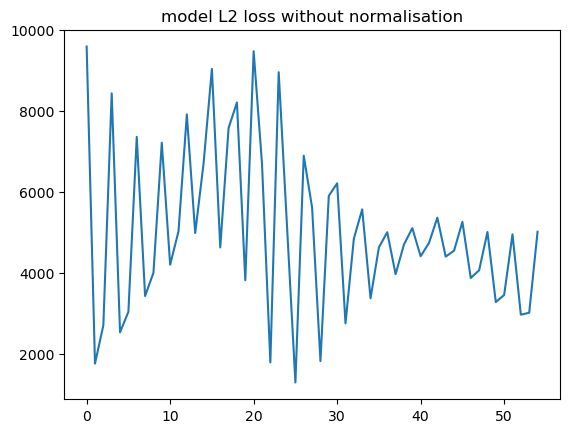

In [25]:
import matplotlib.pyplot as plt
scaler = dataset.column_scalers[dataset.target_labels[2]]
#get the simple loss back from the squared error
scaled_losses = np.ravel(np.power(dataset.denormalize_values(np.sqrt(losses),scaler),2))
plt.plot(scaled_losses[5:])
plt.title('model L2 loss without normalisation')
plt.show()

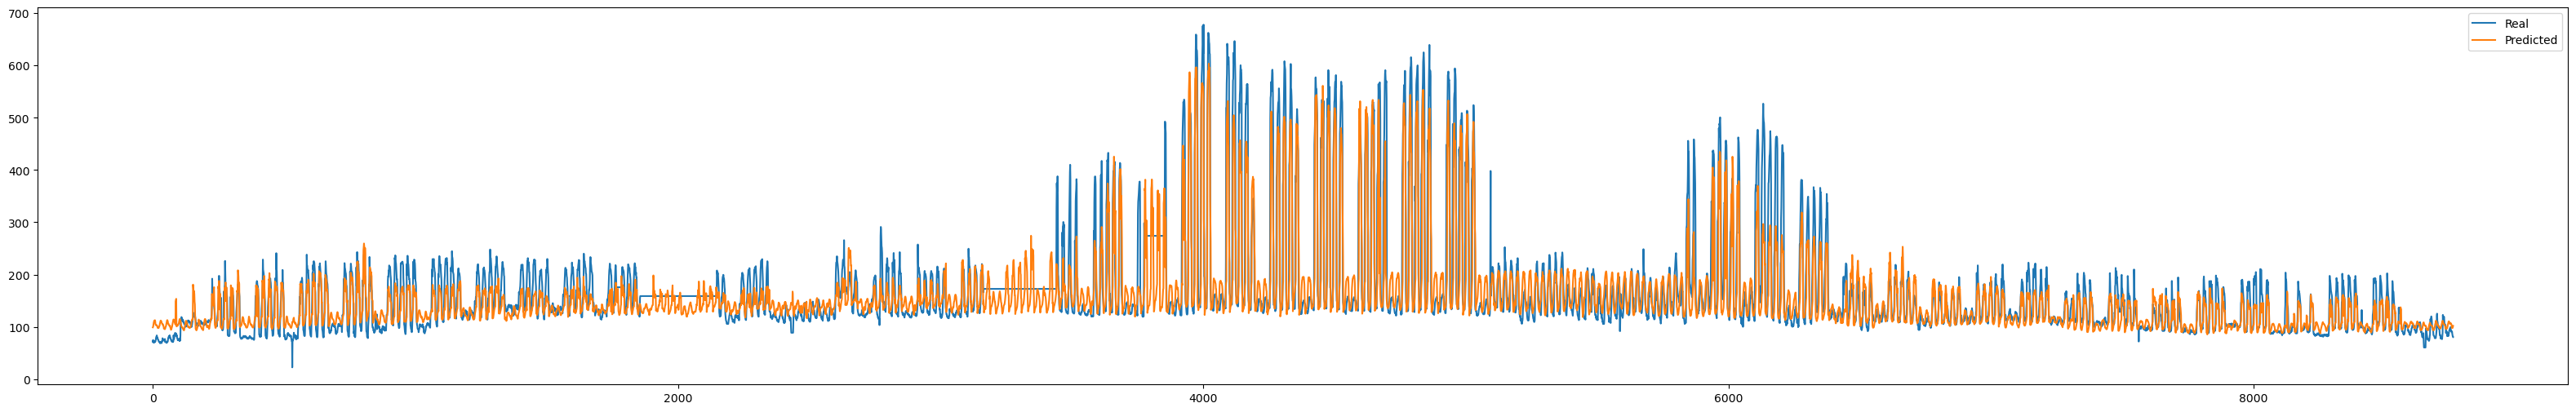

In [21]:
real, pred = predict_consumption(model,dataloader,y_idx=2)
real = [v.item() for v in real]
pred = [v.item() for v in pred]
scaler = dataset.column_scalers[dataset.target_labels[2]]
real_sc = dataset.denormalize_values(real,scaler)
pred_sc = dataset.denormalize_values(pred,scaler)
plt.figure(figsize=(40, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(real_sc, label='Real')  # Add a label for the real data
plt.plot(pred_sc, label='Predicted')  # Add a label for the predicted data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

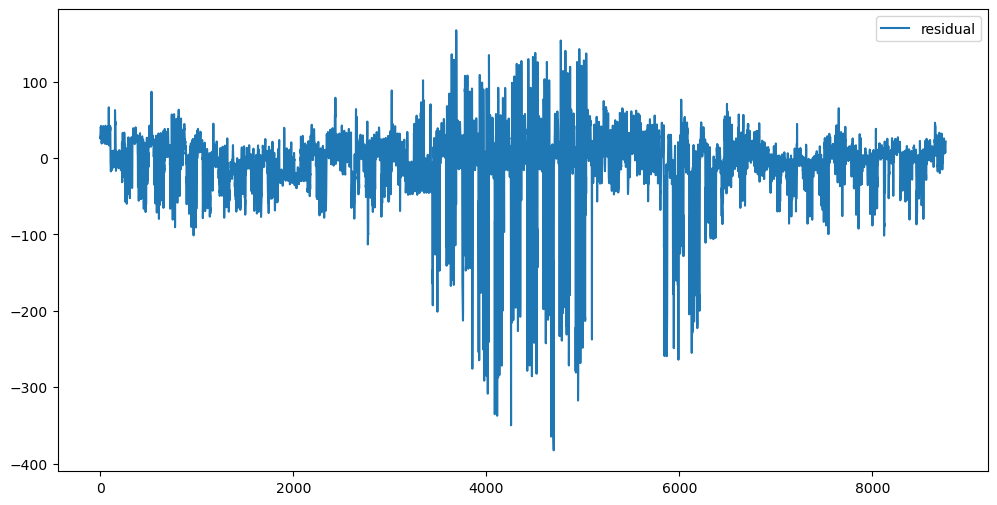

In [22]:
plt.figure(figsize=(12, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(pred_sc-real_sc, label='residual')  # Add a label for the real data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

Now on the 0 energy meter, train on top of the previous

In [28]:
model.init_weights()

In [29]:
num_epochs = 20
losses = train(dataloader, model, batch_size=100, num_epochs=num_epochs,lr=0.0001,y_idx=0)

{'epoch': 0, 'batch': 0, 'loss': 0.010584925301373005}
{'epoch': 0, 'batch': 30, 'loss': 0.04013097658753395}
{'epoch': 0, 'batch': 60, 'loss': 0.030387520790100098}
{'epoch': 1, 'batch': 0, 'loss': 0.011781113222241402}
{'epoch': 1, 'batch': 30, 'loss': 0.025473928079009056}
{'epoch': 1, 'batch': 60, 'loss': 0.021397532895207405}
{'epoch': 2, 'batch': 0, 'loss': 0.012473813258111477}
{'epoch': 2, 'batch': 30, 'loss': 0.021618980914354324}
{'epoch': 2, 'batch': 60, 'loss': 0.01685323566198349}
{'epoch': 3, 'batch': 0, 'loss': 0.013648273423314095}
{'epoch': 3, 'batch': 30, 'loss': 0.020779764279723167}
{'epoch': 3, 'batch': 60, 'loss': 0.013716816902160645}
{'epoch': 4, 'batch': 0, 'loss': 0.014612404629588127}
{'epoch': 4, 'batch': 30, 'loss': 0.016251856461167336}
{'epoch': 4, 'batch': 60, 'loss': 0.013636201620101929}
{'epoch': 5, 'batch': 0, 'loss': 0.01601463556289673}
{'epoch': 5, 'batch': 30, 'loss': 0.015432662330567837}
{'epoch': 5, 'batch': 60, 'loss': 0.012808715924620628}
{

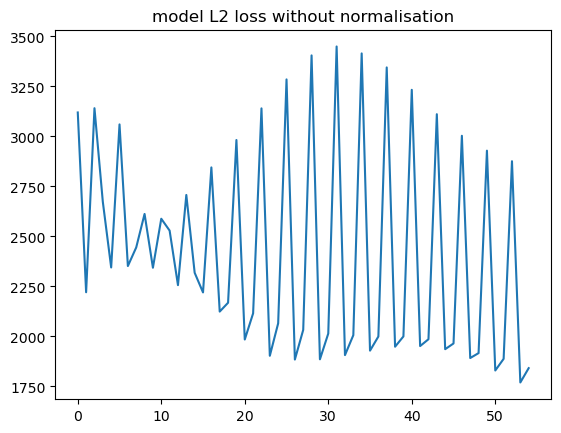

In [30]:
import matplotlib.pyplot as plt
scaler = dataset.column_scalers[dataset.target_labels[0]]
#get the simple loss back from the squared error
scaled_losses = np.ravel(np.power(dataset.denormalize_values(np.sqrt(losses),scaler),2))
plt.plot(scaled_losses[5:])
plt.title('model L2 loss without normalisation')
plt.show()

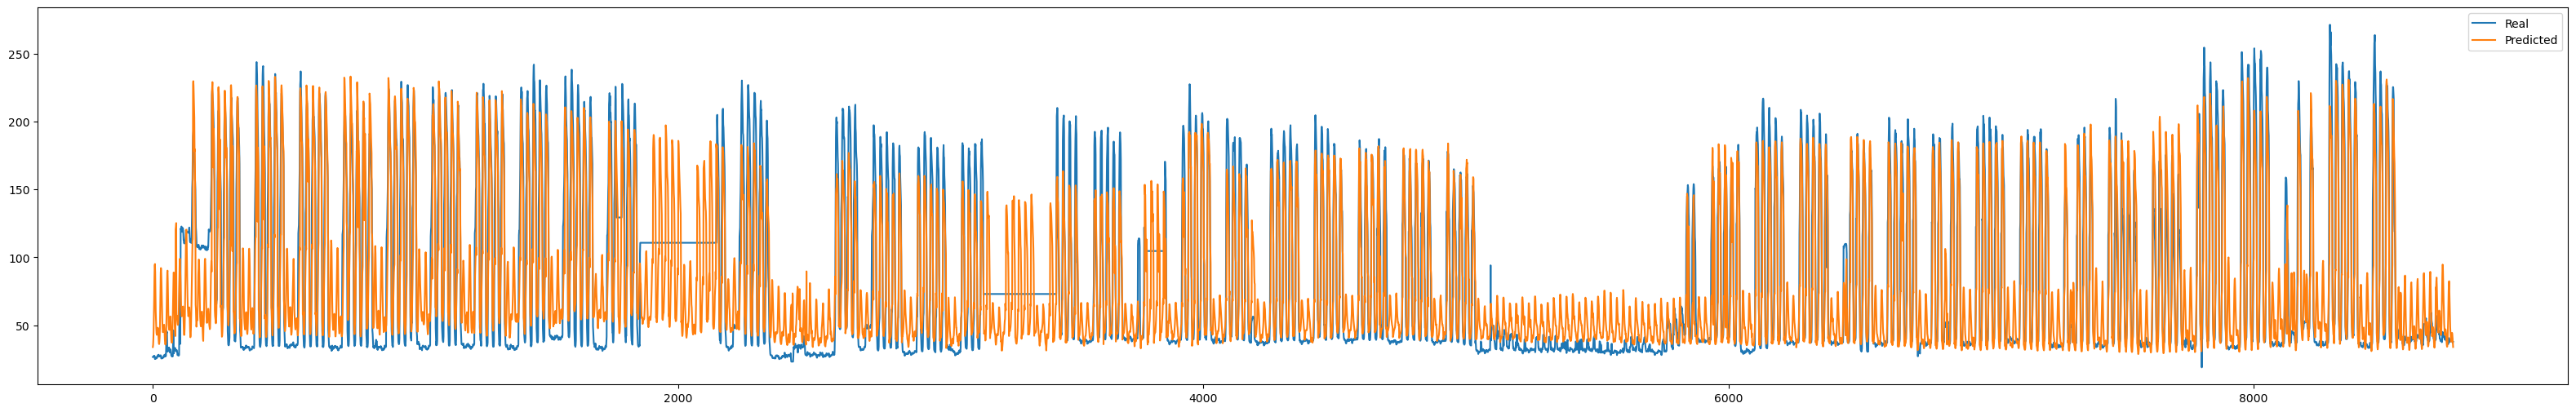

In [31]:
real, pred = predict_consumption(model,dataloader,y_idx=0)
real = [v.item() for v in real]
pred = [v.item() for v in pred]
scaler = dataset.column_scalers[dataset.target_labels[0]]
real_sc = dataset.denormalize_values(real,scaler)
pred_sc = dataset.denormalize_values(pred,scaler)
plt.figure(figsize=(40, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(real_sc, label='Real')  # Add a label for the real data
plt.plot(pred_sc, label='Predicted')  # Add a label for the predicted data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

Try shuffling the data before feeding it.

In [32]:
#now you can create a dataloader and use it!
batch_size = 100
dataloader = DataLoader(dataset, batch_size, shuffle=True)

In [33]:
num_epochs = 20
losses = train(dataloader, model, batch_size=100, num_epochs=num_epochs,lr=0.0001,y_idx=0)

{'epoch': 0, 'batch': 0, 'loss': 0.01163000799715519}
{'epoch': 0, 'batch': 30, 'loss': 0.012723731808364391}
{'epoch': 0, 'batch': 60, 'loss': 0.012465065345168114}
{'epoch': 1, 'batch': 0, 'loss': 0.01709909550845623}
{'epoch': 1, 'batch': 30, 'loss': 0.014502118341624737}
{'epoch': 1, 'batch': 60, 'loss': 0.013963624835014343}
{'epoch': 2, 'batch': 0, 'loss': 0.015825312584638596}
{'epoch': 2, 'batch': 30, 'loss': 0.015281965024769306}
{'epoch': 2, 'batch': 60, 'loss': 0.013732612133026123}
{'epoch': 3, 'batch': 0, 'loss': 0.012219378724694252}
{'epoch': 3, 'batch': 30, 'loss': 0.017317382618784904}
{'epoch': 3, 'batch': 60, 'loss': 0.009161504916846752}
{'epoch': 4, 'batch': 0, 'loss': 0.01116050686687231}
{'epoch': 4, 'batch': 30, 'loss': 0.010708563029766083}
{'epoch': 4, 'batch': 60, 'loss': 0.01131123024970293}
{'epoch': 5, 'batch': 0, 'loss': 0.013223006390035152}
{'epoch': 5, 'batch': 30, 'loss': 0.013037941418588161}
{'epoch': 5, 'batch': 60, 'loss': 0.009325915016233921}
{'

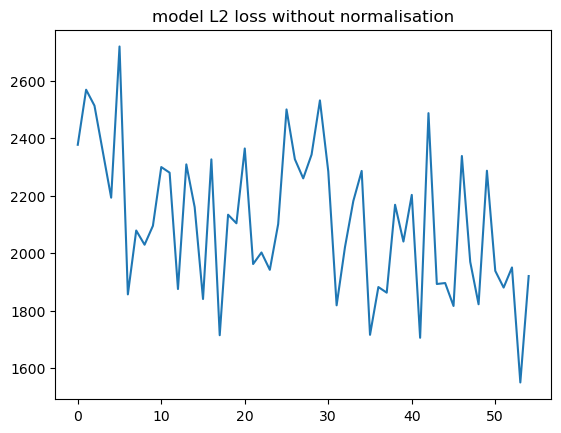

In [34]:
import matplotlib.pyplot as plt
scaler = dataset.column_scalers[dataset.target_labels[0]]
#get the simple loss back from the squared error
scaled_losses = np.ravel(np.power(dataset.denormalize_values(np.sqrt(losses),scaler),2))
plt.plot(scaled_losses[5:])
plt.title('model L2 loss without normalisation')
plt.show()

In [38]:
#now you can create a dataloader and use it!
batch_size = len(dataset)
dataloader = DataLoader(dataset, batch_size, shuffle=False)

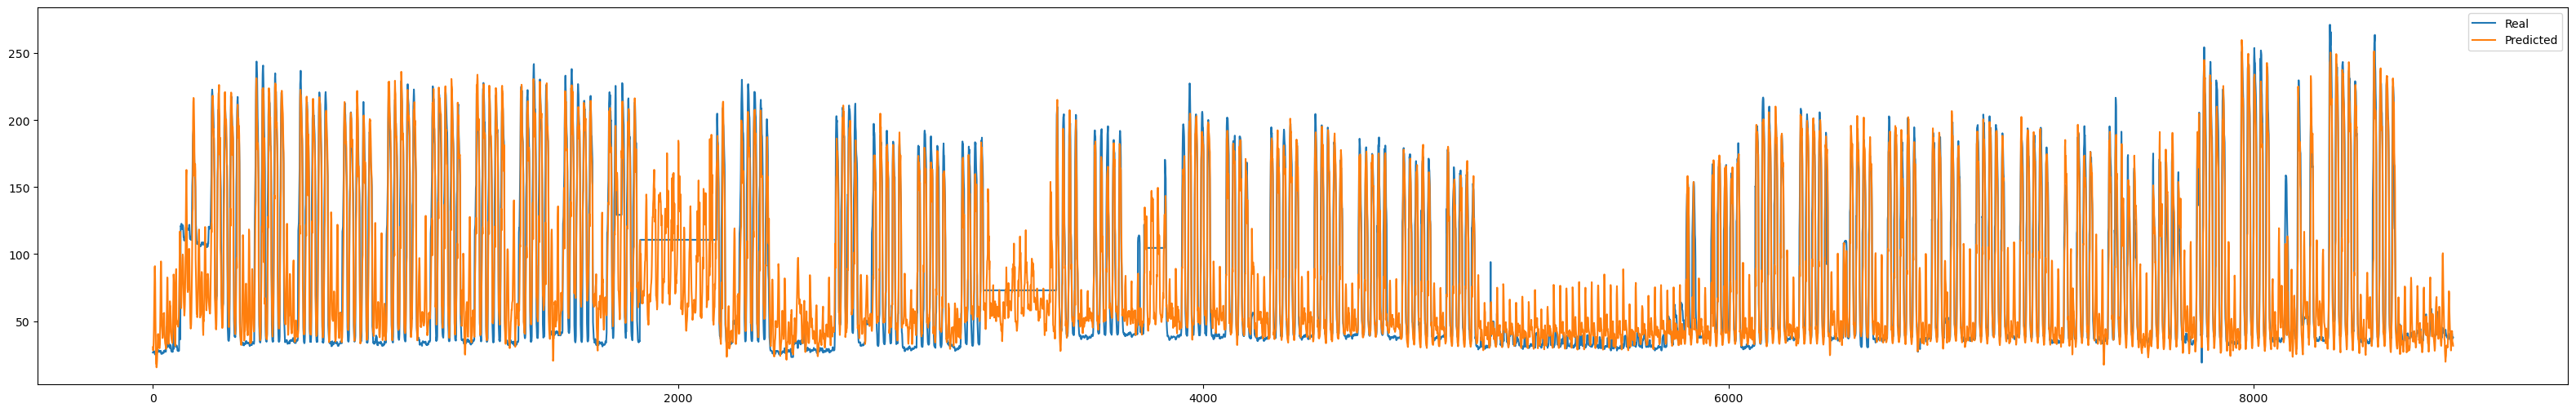

In [39]:
real, pred = predict_consumption(model,dataloader,y_idx=0)
real = [v.item() for v in real]
pred = [v.item() for v in pred]
scaler = dataset.column_scalers[dataset.target_labels[0]]
real_sc = dataset.denormalize_values(real,scaler)
pred_sc = dataset.denormalize_values(pred,scaler)
plt.figure(figsize=(40, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(real_sc, label='Real')  # Add a label for the real data
plt.plot(pred_sc, label='Predicted')  # Add a label for the predicted data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

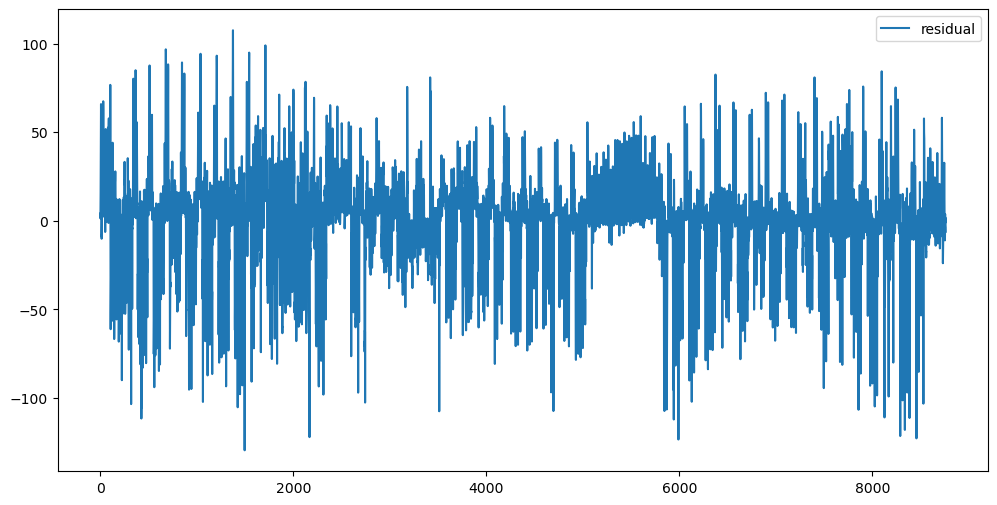

In [40]:
plt.figure(figsize=(12, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(pred_sc-real_sc, label='residual')  # Add a label for the real data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

Another round of 20 epochs

In [42]:
#now you can create a dataloader and use it!
batch_size = 100
dataloader = DataLoader(dataset, batch_size, shuffle=True)

In [43]:
num_epochs = 20
losses = train(dataloader, model, batch_size=100, num_epochs=num_epochs,lr=0.0001,y_idx=0)

{'epoch': 0, 'batch': 0, 'loss': 0.006354108918458223}
{'epoch': 0, 'batch': 30, 'loss': 0.01162472739815712}
{'epoch': 0, 'batch': 60, 'loss': 0.011585729196667671}
{'epoch': 1, 'batch': 0, 'loss': 0.008659496903419495}
{'epoch': 1, 'batch': 30, 'loss': 0.010903440415859222}
{'epoch': 1, 'batch': 60, 'loss': 0.008772148750722408}
{'epoch': 2, 'batch': 0, 'loss': 0.01010819897055626}
{'epoch': 2, 'batch': 30, 'loss': 0.009902533143758774}
{'epoch': 2, 'batch': 60, 'loss': 0.005853248760104179}
{'epoch': 3, 'batch': 0, 'loss': 0.010846649296581745}
{'epoch': 3, 'batch': 30, 'loss': 0.0077377683483064175}
{'epoch': 3, 'batch': 60, 'loss': 0.009041881188750267}
{'epoch': 4, 'batch': 0, 'loss': 0.006126769818365574}
{'epoch': 4, 'batch': 30, 'loss': 0.006708411034196615}
{'epoch': 4, 'batch': 60, 'loss': 0.008801217190921307}
{'epoch': 5, 'batch': 0, 'loss': 0.008148248307406902}
{'epoch': 5, 'batch': 30, 'loss': 0.009476671926677227}
{'epoch': 5, 'batch': 60, 'loss': 0.005942030344158411}

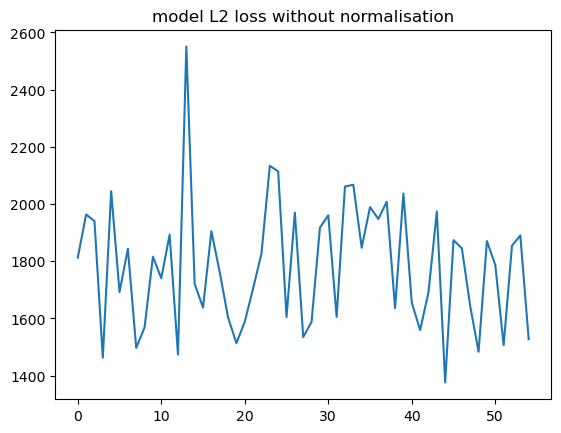

In [44]:
import matplotlib.pyplot as plt
scaler = dataset.column_scalers[dataset.target_labels[0]]
#get the simple loss back from the squared error
scaled_losses = np.ravel(np.power(dataset.denormalize_values(np.sqrt(losses),scaler),2))
plt.plot(scaled_losses[5:])
plt.title('model L2 loss without normalisation')
plt.show()

In [45]:
#now you can create a dataloader and use it!
batch_size = len(dataset)
dataloader = DataLoader(dataset, batch_size, shuffle=False)

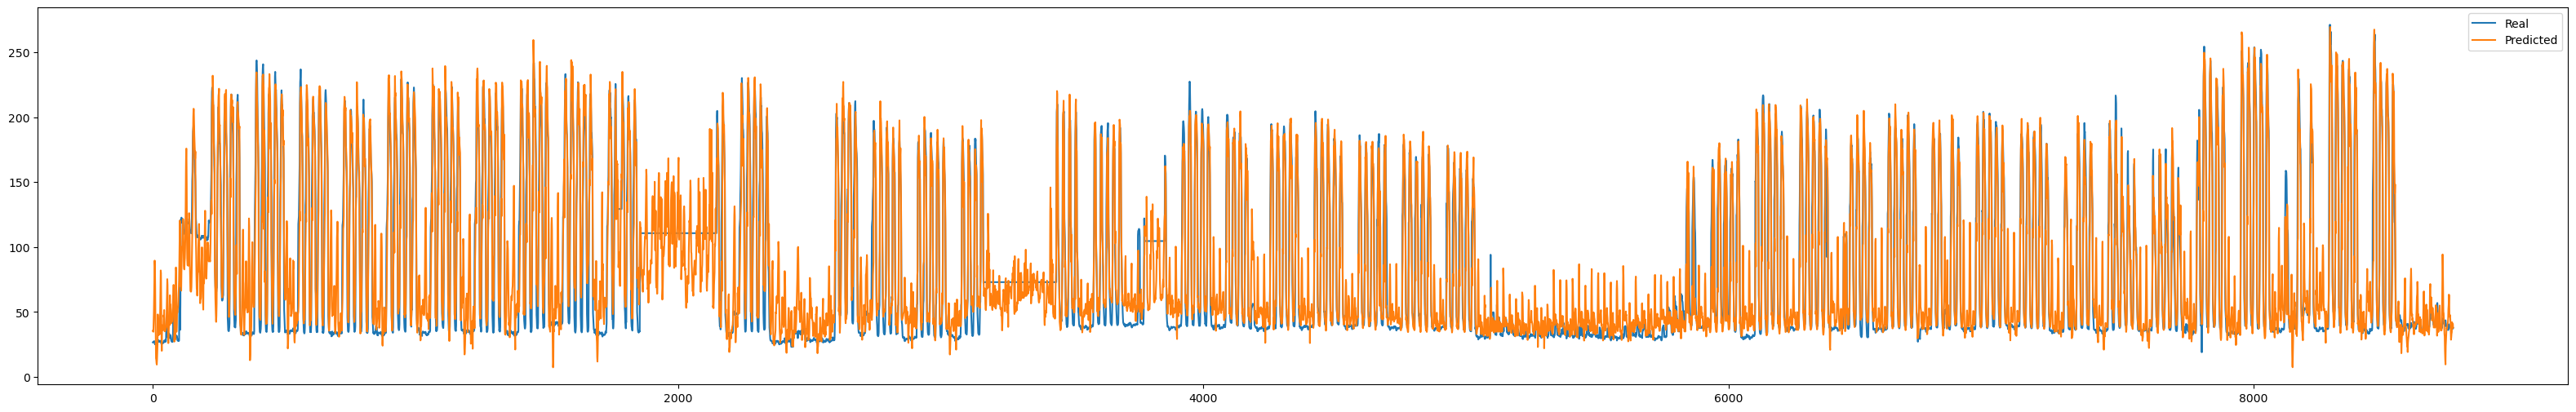

In [46]:
real, pred = predict_consumption(model,dataloader,y_idx=0)
real = [v.item() for v in real]
pred = [v.item() for v in pred]
scaler = dataset.column_scalers[dataset.target_labels[0]]
real_sc = dataset.denormalize_values(real,scaler)
pred_sc = dataset.denormalize_values(pred,scaler)
plt.figure(figsize=(40, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(real_sc, label='Real')  # Add a label for the real data
plt.plot(pred_sc, label='Predicted')  # Add a label for the predicted data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

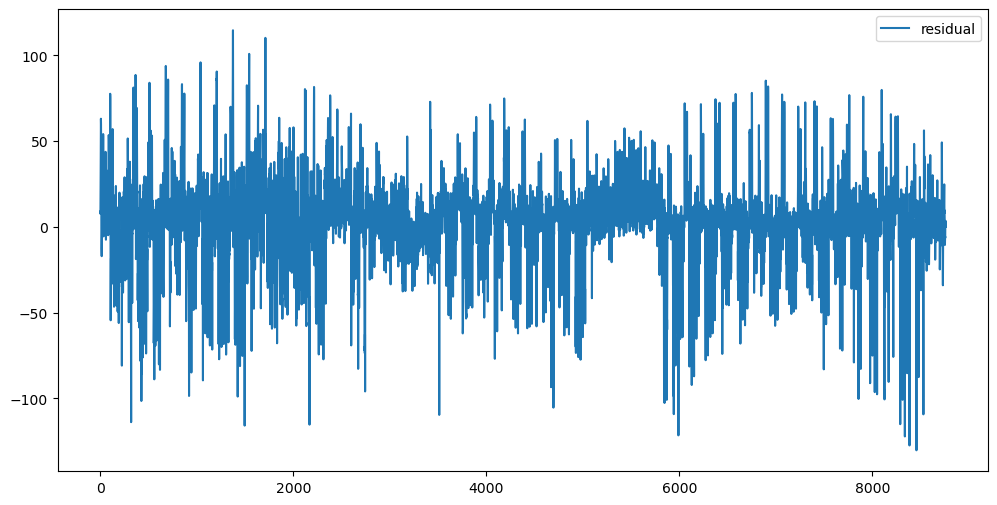

In [47]:
plt.figure(figsize=(12, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(pred_sc-real_sc, label='residual')  # Add a label for the real data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

This model works pretty well, we'll keep it

## Keep the sort of transformer model

We'll do grid search of the best parameters and report everything in w&b, we'll only do this for one of the energy counters (y0) and then use the same hyperparams for all models.

In [67]:
import wandb

!wandb login

wandb: Currently logged in as: haradai (energy_project_uab). Use `wandb login --relogin` to force relogin


In [ ]:
device = "mps"

In [ ]:
from models.attention_exp_LSTM.dataset import energyProject_dataset
from models.attention_exp_LSTM.network import attentiveLSTM_model

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pickle
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import pandas as pd
import yaml
import wandb
from typing import Dict
import matplotlib.pyplot as plt

In [ ]:
def nested_dict(original_dict):
    nested_dict = {}
    for key, value in original_dict.items():
        parts = key.split(".")
        d = nested_dict
        for part in parts[:-1]:
            if part not in d:
                d[part] = {}
            d = d[part]
        d[parts[-1]] = value
    return nested_dict


#load dataset object file
with (open('data/dataset_class.pkl', "rb")) as openfile:
    dataset = pickle.load(openfile)

dataset.activitivity_encoding_mode = 2 #or any value
# Splitting the dataset into training and validation sets
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42, shuffle=False )

train_dataloader = DataLoader(train_data, batch_size=100, shuffle=False) #!!! useful to shuffle?
val_dataloader = DataLoader(val_data, batch_size=100, shuffle=False)
whole_dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

In [ ]:
#setup wandb stuff
with open('models/attention_exp_LSTM/config.yaml', 'r') as stream:
    try:
        sweep_config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [ ]:
y_idx=0

In [ ]:
scaler = dataset.column_scalers[dataset.target_labels[y_idx]]

In [ ]:
def train(config: Dict = None):
    with wandb.init(config=config) as run:
        run.name = "ENERGY_METER_0"
        config = wandb.config
        config = nested_dict(config)
        optimizer_config = config["optimizer"]
        model = attentiveLSTM_model(espai_emb_dim=config["espai_emb_dim"],hidden_dim=config['hidden_size'],lstm_nl=config['num_layers'],nheads=config['heads'],attnFCdim=config['attnFCdim'])
        model.init_weights()
        model.to(device)

        criterion =  nn.MSELoss()

        if optimizer_config["type"] == 'adam':
            optimizer = torch.optim.Adam(model.parameters(), lr = optimizer_config['lr'])

        num_epochs = 80
        best_loss = float('inf')
        for epoch in range(num_epochs):
            model.train()
            training_losses = [] # renamed from epoch_losses
            progress_bar = tqdm(enumerate(train_dataloader), desc=f"Epoch {epoch + 1}/{num_epochs}")
            for batch,data in progress_bar:
                ocu_emb, espai_enc, general_data = data["ocu_ber_emb"].float().to(device) ,data["espai_enc"].float().to(device) ,data["general_data"].float().to(device)
                y = data["y"][:,y_idx].float().to(device) #we'll do one counter for now

                optimizer.zero_grad()
                
                #current batch size size
                b_sz = ocu_emb.shape[0]

                #note the dataloader with a batch of 100 when reachs the end expects a batch of 60
                h, c = model.init_hidden(b_sz) # Start with a new state in each batch            
                h = h.to(device)
                c = c.to(device)
                y_pred, h,c= model(ocu_emb, espai_enc, general_data, h, c)
                y_pred = y_pred[:,0,0]

                loss = criterion(y_pred,y)  #cross entropy loss needs (N,C,seq_lenght)
                loss.backward()
                optimizer.step()    

                training_losses.append(loss.item())
                progress_bar.set_postfix({'Batch Loss': loss.item()})

            average_training_loss = sum(training_losses) / len(training_losses) # renamed from avg_loss
            #average_training_loss = np.power(dataset.denormalize_values(np.sqrt(average_training_loss),scaler),2)
            wandb.log({'Train_Epoch_Loss': average_training_loss})

            model.eval()  
            with torch.no_grad():  
                validation_losses = [] # renamed from val_losses
                for batch in tqdm(val_dataloader, desc='Validation'):
                    ocu_emb, espai_enc, general_data = data["ocu_ber_emb"].float().to(device) ,data["espai_enc"].float().to(device) ,data["general_data"].float().to(device)
                    y = data["y"][:,y_idx].float().to(device) #we'll do one counter for now

                    #current batch size size
                    b_sz = ocu_emb.shape[0]

                    #note the dataloader with a batch of 100 when reachs the end expects a batch of 60
                    h, c = model.init_hidden(b_sz) # Start with a new state in each batch            
                    h = h.to(device)
                    c = c.to(device)
                    y_pred, h,c= model(ocu_emb, espai_enc, general_data, h, c)
                    y_pred = y_pred[:,0,0]
                    
                    loss = criterion(y_pred,y) 
                    validation_losses.append(loss.item())

                average_validation_loss = sum(validation_losses) / len(validation_losses) # renamed from avg_val_loss
                #average_validation_loss = np.power(dataset.denormalize_values(np.sqrt(average_validation_loss),scaler),2)
                wandb.log({'Validation_Epoch_Loss': average_validation_loss})

            if average_training_loss < best_loss:
                best_loss = average_training_loss
                torch.save(model.state_dict(), 'models/attention_exp_LSTM/tranformLSTM.pt')
                wandb.save('gru_model.pt')
                print(f"Model saved at {'gru_model.pt'}")

        wandb.finish()

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="energy_project_uab")
sweep_id

In [ ]:
wandb.agent(sweep_id, function=train)

The sweep result can be found in our wandb page: https://wandb.ai/energy_project_uab/energy_project_uab?workspace=user-haradai

From out sweep these are the best parameters found: Let's train again such a model but for many more epochs:

# Training a model for each energy meter:

# y = 0

In [ ]:
y_idx = 0
model = attentiveLSTM_model(espai_emb_dim=50,hidden_dim=384,lstm_nl=1,nheads=2,attnFCdim=80)
model.init_weights()
model.to(device)

criterion =  nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) #lr used in that 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=(1 - 0.0001 / 0.001))
num_epochs = 200
best_loss = float('inf')
epoch_loss_tr = []
epoch_loss_vl = []
with wandb.init(project="energy_project_uab", entity = "energy_project_uab") as run:
    run.name = f"LSTM_attention_regressor_0"
    for epoch in range(num_epochs):
        model.train()
        training_losses = [] # renamed from epoch_losses
        progress_bar = tqdm(enumerate(train_dataloader), desc=f"Epoch {epoch + 1}/{num_epochs}")
        for batch,data in progress_bar:
            ocu_emb, espai_enc, general_data = data["ocu_ber_emb"].float().to(device) ,data["espai_enc"].float().to(device) ,data["general_data"].float().to(device)
            y = data["y"][:,y_idx].float().to(device) #we'll do one counter for now

            optimizer.zero_grad()
            
            #current batch size size
            b_sz = ocu_emb.shape[0]

            #note the dataloader with a batch of 100 when reachs the end expects a batch of 60
            h, c = model.init_hidden(b_sz) # Start with a new state in each batch            
            h = h.to(device)
            c = c.to(device)
            y_pred, h,c= model(ocu_emb, espai_enc, general_data, h, c)
            y_pred = y_pred[:,0,0]

            loss = criterion(y_pred,y)  #cross entropy loss needs (N,C,seq_lenght)
            loss.backward()
            optimizer.step()    

            training_losses.append(loss.item())
            progress_bar.set_postfix({'Batch Loss': loss.item()})

        average_training_loss = sum(training_losses) / len(training_losses) # renamed from avg_loss
        epoch_loss_tr.append(average_training_loss)
        wandb.log({"Train_loss":average_training_loss})
        #average_training_loss = np.power(dataset.denormalize_values(np.sqrt(average_training_loss),scaler),2)

        model.eval()  
        with torch.no_grad():  
            validation_losses = [] # renamed from val_losses
            for batch in tqdm(val_dataloader, desc='Validation'):
                ocu_emb, espai_enc, general_data = data["ocu_ber_emb"].float().to(device) ,data["espai_enc"].float().to(device) ,data["general_data"].float().to(device)
                y = data["y"][:,y_idx].float().to(device) #we'll do one counter for now

                #current batch size size
                b_sz = ocu_emb.shape[0]

                #note the dataloader with a batch of 100 when reachs the end expects a batch of 60
                h, c = model.init_hidden(b_sz) # Start with a new state in each batch            
                h = h.to(device)
                c = c.to(device)
                y_pred, h,c= model(ocu_emb, espai_enc, general_data, h, c)
                y_pred = y_pred[:,0,0]
                
                loss = criterion(y_pred,y) 
                validation_losses.append(loss.item())

            average_validation_loss = sum(validation_losses) / len(validation_losses) # renamed from avg_val_loss
            #average_validation_loss = np.power(dataset.denormalize_values(np.sqrt(average_validation_loss),scaler),2)
            epoch_loss_vl.append(average_validation_loss)
            wandb.log({"Val_loss":average_validation_loss})
        
        scheduler.step() #change lr
        print(f"lr:{scheduler.get_last_lr()}")#print current lr

        if average_validation_loss < best_loss:
            best_loss = average_training_loss
            torch.save(model.state_dict(), 'models/attention_exp_LSTM/LSTM_attention_regressor_0.pt')
            wandb.save('models/attention_exp_LSTM/LSTM_attention_regressor_0.pt')
            print("Model saved at models/attention_exp_LSTM/LSTM_attention_regressor_0.pt")
        
        if epoch == num_epochs-1: #if last epoch just finished
            print("Running whole dataset prediction")
            real, pred = predict_consumption(model,whole_dataloader,y_idx=0)
            real = [v.item() for v in real]
            pred = [v.item() for v in pred]
            scaler = dataset.column_scalers[dataset.target_labels[y_idx]]
            real_sc = dataset.denormalize_values(real,scaler)
            pred_sc = dataset.denormalize_values(pred,scaler)
            res_sc = pred_sc-real_sc
           # Plotting the main data
            plt.subplot(2, 1, 1)  # Create a subplot with 2 rows and 1 column, and select the first subplot
            plt.plot(real_sc, label='Real')  # Add a label for the real data
            plt.plot(pred_sc, label='Predicted')  # Add a label for the predicted data

            # Plotting the residual data
            plt.subplot(2, 1, 2)  # Select the second subplot
            plt.plot(res_sc, label='Residual')  # Add a label for the residual data
            wandb.log({"KWh hourly in 2022": plt})

                        # Display the plot
            plt.show()

                    
    wandb.finish()

# Y=1

In [ ]:
y_idx = 1
model = attentiveLSTM_model(espai_emb_dim=50,hidden_dim=384,lstm_nl=1,nheads=2,attnFCdim=80)
model.init_weights()
model.to(device)

criterion =  nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) #lr used in that 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=(1 - 0.0001 / 0.001))
num_epochs = 200
best_loss = float('inf')
epoch_loss_tr = []
epoch_loss_vl = []
with wandb.init(project="energy_project_uab", entity = "energy_project_uab") as run:
    run.name = f"LSTM_attention_regressor_1"
    for epoch in range(num_epochs):
        model.train()
        training_losses = [] # renamed from epoch_losses
        progress_bar = tqdm(enumerate(train_dataloader), desc=f"Epoch {epoch + 1}/{num_epochs}")
        for batch,data in progress_bar:
            ocu_emb, espai_enc, general_data = data["ocu_ber_emb"].float().to(device) ,data["espai_enc"].float().to(device) ,data["general_data"].float().to(device)
            y = data["y"][:,y_idx].float().to(device) #we'll do one counter for now

            optimizer.zero_grad()
            
            #current batch size size
            b_sz = ocu_emb.shape[0]

            #note the dataloader with a batch of 100 when reachs the end expects a batch of 60
            h, c = model.init_hidden(b_sz) # Start with a new state in each batch            
            h = h.to(device)
            c = c.to(device)
            y_pred, h,c= model(ocu_emb, espai_enc, general_data, h, c)
            y_pred = y_pred[:,0,0]

            loss = criterion(y_pred,y)  #cross entropy loss needs (N,C,seq_lenght)
            loss.backward()
            optimizer.step()    

            training_losses.append(loss.item())
            progress_bar.set_postfix({'Batch Loss': loss.item()})

        average_training_loss = sum(training_losses) / len(training_losses) # renamed from avg_loss
        epoch_loss_tr.append(average_training_loss)
        wandb.log({"Train_loss":average_training_loss})
        #average_training_loss = np.power(dataset.denormalize_values(np.sqrt(average_training_loss),scaler),2)

        model.eval()  
        with torch.no_grad():  
            validation_losses = [] # renamed from val_losses
            for batch in tqdm(val_dataloader, desc='Validation'):
                ocu_emb, espai_enc, general_data = data["ocu_ber_emb"].float().to(device) ,data["espai_enc"].float().to(device) ,data["general_data"].float().to(device)
                y = data["y"][:,y_idx].float().to(device) #we'll do one counter for now

                #current batch size size
                b_sz = ocu_emb.shape[0]

                #note the dataloader with a batch of 100 when reachs the end expects a batch of 60
                h, c = model.init_hidden(b_sz) # Start with a new state in each batch            
                h = h.to(device)
                c = c.to(device)
                y_pred, h,c= model(ocu_emb, espai_enc, general_data, h, c)
                y_pred = y_pred[:,0,0]
                
                loss = criterion(y_pred,y) 
                validation_losses.append(loss.item())

            average_validation_loss = sum(validation_losses) / len(validation_losses) # renamed from avg_val_loss
            #average_validation_loss = np.power(dataset.denormalize_values(np.sqrt(average_validation_loss),scaler),2)
            epoch_loss_vl.append(average_validation_loss)
            wandb.log({"Val_loss":average_validation_loss})
        
        scheduler.step() #change lr
        print(f"lr:{scheduler.get_last_lr()}")#print current lr

        if average_validation_loss < best_loss:
            best_loss = average_training_loss
            torch.save(model.state_dict(), 'models/attention_exp_LSTM/LSTM_attention_regressor_1.pt')
            wandb.save('models/attention_exp_LSTM/LSTM_attention_regressor_1.pt')
            print("Model saved at models/attention_exp_LSTM/LSTM_attention_regressor_1.pt")
        
        if epoch == num_epochs-1: #if last epoch just finished
            print("Running whole dataset prediction")
            real, pred = predict_consumption(model,whole_dataloader,y_idx)
            real = [v.item() for v in real]
            pred = [v.item() for v in pred]
            scaler = dataset.column_scalers[dataset.target_labels[y_idx]]
            real_sc = dataset.denormalize_values(real,scaler)
            pred_sc = dataset.denormalize_values(pred,scaler)
            res_sc = pred_sc-real_sc
           # Plotting the main data
            plt.subplot(2, 1, 1)  # Create a subplot with 2 rows and 1 column, and select the first subplot
            plt.plot(real_sc, label='Real')  # Add a label for the real data
            plt.plot(pred_sc, label='Predicted')  # Add a label for the predicted data

            # Plotting the residual data
            plt.subplot(2, 1, 2)  # Select the second subplot
            plt.plot(res_sc, label='Residual')  # Add a label for the residual data
            wandb.log({"KWh hourly in 2022": plt})

                        # Display the plot
            plt.show()

                    
    wandb.finish()

# Y=2

In [ ]:
y_idx = 2
model = attentiveLSTM_model(espai_emb_dim=50,hidden_dim=384,lstm_nl=1,nheads=2,attnFCdim=80)
model.init_weights()
model.to(device)

criterion =  nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) #lr used in that 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=(1 - 0.0001 / 0.001))
num_epochs = 200
best_loss = float('inf')
epoch_loss_tr = []
epoch_loss_vl = []
with wandb.init(project="energy_project_uab", entity = "energy_project_uab") as run:
    run.name = f"LSTM_attention_regressor_2"
    for epoch in range(num_epochs):
        model.train()
        training_losses = [] # renamed from epoch_losses
        progress_bar = tqdm(enumerate(train_dataloader), desc=f"Epoch {epoch + 1}/{num_epochs}")
        for batch,data in progress_bar:
            ocu_emb, espai_enc, general_data = data["ocu_ber_emb"].float().to(device) ,data["espai_enc"].float().to(device) ,data["general_data"].float().to(device)
            y = data["y"][:,y_idx].float().to(device) #we'll do one counter for now

            optimizer.zero_grad()
            
            #current batch size size
            b_sz = ocu_emb.shape[0]

            #note the dataloader with a batch of 100 when reachs the end expects a batch of 60
            h, c = model.init_hidden(b_sz) # Start with a new state in each batch            
            h = h.to(device)
            c = c.to(device)
            y_pred, h,c= model(ocu_emb, espai_enc, general_data, h, c)
            y_pred = y_pred[:,0,0]

            loss = criterion(y_pred,y)  #cross entropy loss needs (N,C,seq_lenght)
            loss.backward()
            optimizer.step()    

            training_losses.append(loss.item())
            progress_bar.set_postfix({'Batch Loss': loss.item()})

        average_training_loss = sum(training_losses) / len(training_losses) # renamed from avg_loss
        epoch_loss_tr.append(average_training_loss)
        wandb.log({"Train_loss":average_training_loss})
        #average_training_loss = np.power(dataset.denormalize_values(np.sqrt(average_training_loss),scaler),2)

        model.eval()  
        with torch.no_grad():  
            validation_losses = [] # renamed from val_losses
            for batch in tqdm(val_dataloader, desc='Validation'):
                ocu_emb, espai_enc, general_data = data["ocu_ber_emb"].float().to(device) ,data["espai_enc"].float().to(device) ,data["general_data"].float().to(device)
                y = data["y"][:,y_idx].float().to(device) #we'll do one counter for now

                #current batch size size
                b_sz = ocu_emb.shape[0]

                #note the dataloader with a batch of 100 when reachs the end expects a batch of 60
                h, c = model.init_hidden(b_sz) # Start with a new state in each batch            
                h = h.to(device)
                c = c.to(device)
                y_pred, h,c= model(ocu_emb, espai_enc, general_data, h, c)
                y_pred = y_pred[:,0,0]
                
                loss = criterion(y_pred,y) 
                validation_losses.append(loss.item())

            average_validation_loss = sum(validation_losses) / len(validation_losses) # renamed from avg_val_loss
            #average_validation_loss = np.power(dataset.denormalize_values(np.sqrt(average_validation_loss),scaler),2)
            epoch_loss_vl.append(average_validation_loss)
            wandb.log({"Val_loss":average_validation_loss})
        
        scheduler.step() #change lr
        print(f"lr:{scheduler.get_last_lr()}")#print current lr

        if average_validation_loss < best_loss:
            best_loss = average_training_loss
            torch.save(model.state_dict(), 'models/attention_exp_LSTM/LSTM_attention_regressor_2.pt')
            wandb.save('models/attention_exp_LSTM/LSTM_attention_regressor_2.pt')
            print("Model saved at models/attention_exp_LSTM/LSTM_attention_regressor_2.pt")
        
        if epoch == num_epochs-1: #if last epoch just finished
            print("Running whole dataset prediction")
            real, pred = predict_consumption(model,whole_dataloader,y_idx)
            real = [v.item() for v in real]
            pred = [v.item() for v in pred]
            scaler = dataset.column_scalers[dataset.target_labels[y_idx]]
            real_sc = dataset.denormalize_values(real,scaler)
            pred_sc = dataset.denormalize_values(pred,scaler)
            res_sc = pred_sc-real_sc
           # Plotting the main data
            plt.subplot(2, 1, 1)  # Create a subplot with 2 rows and 1 column, and select the first subplot
            plt.plot(real_sc, label='Real')  # Add a label for the real data
            plt.plot(pred_sc, label='Predicted')  # Add a label for the predicted data

            # Plotting the residual data
            plt.subplot(2, 1, 2)  # Select the second subplot
            plt.plot(res_sc, label='Residual')  # Add a label for the residual data
            wandb.log({"KWh hourly in 2022": plt})

                        # Display the plot
            plt.show()

                    
    wandb.finish()

# The optimizer model:

We thought that instead of doing that manually by trying and error we will create a second model, given this first one is frozen that will try to minimize the energy consumption by given some input of activities generating the Espai where it should be hold in. We'll put in an important loss for repeating the same espai for different activities. 

Then we'll do the same but for the opposite, make it attempt to using the same mechanism make the energy consumption as high as possible. This way with both, we'll be able to detect what "espais" are related with more consumption.

We could further do the same for activities but we are going to keep it simple for now...

## Model:

In [ ]:
# %%
from icecream import ic

# %%
device = "cuda"

# %%
from models.attention_exp_LSTM.dataset import energyProject_dataset
from models.attention_exp_LSTM.network import attentiveLSTM_model 
from models.attention_exp_LSTM.network import SpaceActOptim_model

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pickle
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import pandas as pd
import yaml
import wandb
from typing import Dict
import matplotlib.pyplot as plt

# %%
#load dataset object file
with (open('data/dataset_class.pkl', "rb")) as openfile:
    dataset = pickle.load(openfile)

dataset.activitivity_encoding_mode = 2 #or any value
# Splitting the dataset into training and validation sets
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42, shuffle=False )

train_dataloader = DataLoader(train_data, batch_size=100, shuffle=False) #!!! useful to shuffle?
val_dataloader = DataLoader(val_data, batch_size=100, shuffle=False)
whole_dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# %% [markdown]
# Now that we have seen how this assignment process works, lets put it all together and train a model.

# %% [markdown]
# We'll start loading the already trained y=0 regressor.

# %% [markdown]
# We have to modify this function to be able to generate the prediction graph with the modified espai occupation

# %%
def predict_consumption_opti(model,opti_model,dataloader,y_idx):
    real = []
    pred = []
    h, c = model.init_hidden(dataloader.batch_size) # Start with a new state in each batch            
    h = h.to(device)
    c = c.to(device)
    real_assigns = []
    pred_assigns = []
    h, c = model.init_hidden(1) # Start with a new state in each batch   
    print("running predictions...")   
    for batch, data in tqdm(enumerate(dataloader),total=len(dataset)):
        with torch.no_grad():
            #current batch size size
            ocu_emb, espai_enc, general_data = data["ocu_ber_emb"].float().to(device) ,data["espai_enc"].float().to(device) ,data["general_data"].float().to(device)
            y = data["y"][:,y_idx].float().to(device) #we'll do one counter for now
            
            gener_espai_enc = opti_model(ocu_emb,general_data)
            
            #save assigns for further analysis
            real_assigns += list(espai_enc.view(espai_enc.shape[0]*espai_enc.shape[1]).detach().to("cpu").numpy())
            pred_assigns += list(gener_espai_enc.view(gener_espai_enc.shape[0]*gener_espai_enc.shape[1]).detach().to("cpu").numpy())
            
            h = h.to(device)
            c = c.to(device)
            y_pred, h,c= model(ocu_emb, gener_espai_enc, general_data, h, c)
            pred += list(y_pred[:,0,0].to("cpu"))
            real += list(y.to("cpu"))
    
    return real ,pred, real_assigns, pred_assigns

# %%
def predict_consumption(model,dataloader,y_idx):
    real = []
    pred = []
    h, c = model.init_hidden(dataloader.batch_size) # Start with a new state in each batch            
    h = h.to(device)
    c = c.to(device)
    h, c = model.init_hidden(1) # Start with a new state in each batch    
    print("running predictions...")     
    for batch, data in tqdm(enumerate(dataloader),total=len(dataset)):
        with torch.no_grad():
            #current batch size size
            ocu_emb, espai_enc, general_data = data["ocu_ber_emb"].float().to(device) ,data["espai_enc"].float().to(device) ,data["general_data"].float().to(device)
            y = data["y"][:,y_idx].float().to(device) #we'll do one counter for now
            h = h.to(device)
            c = c.to(device)
            y_pred, h,c= model(ocu_emb, espai_enc, general_data, h, c)
            pred += list(y_pred[:,0,0].to("cpu"))
            real += list(y.to("cpu"))
    return real ,pred

# %% [markdown]
# # Y=0

# %%
y_idx = 0

# %%
model_enpr = attentiveLSTM_model(espai_emb_dim=50,hidden_dim=384,lstm_nl=1,nheads=2,attnFCdim=80)
model_enpr.load_state_dict(torch.load(f"models/attention_exp_LSTM/LSTM_attention_regressor_{y_idx}.pt",map_location=torch.device("cpu")))
model_enpr = model_enpr.to(device)
model_enpr.requires_grad_ = False #freeze our model
opti_model = SpaceActOptim_model(hidden_dim=800,nheads=2,attnFCdim=400)
opti_model = opti_model.to(device)

optimizer = torch.optim.Adam(opti_model.parameters(), lr = 0.001) #lr used in that 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=(1 - 0.0001 / 0.001))
num_epochs = 100
best_loss = float('inf')
epoch_loss_tr = []
epoch_loss_vl = []
with wandb.init(project="energy_project_uab", entity = "energy_project_uab") as run:
    run.name = f"opti_model_{y_idx}.pt"
    for epoch in range(num_epochs):
        opti_model.train()
        training_losses = [] # renamed from epoch_losses
        progress_bar = tqdm(enumerate(train_dataloader), desc=f"Epoch {epoch + 1}/{num_epochs}")
        for batch,data in progress_bar:
            ocu_emb, espai_enc, general_data = data["ocu_ber_emb"].float().to(device) ,data["espai_enc"].float().to(device) ,data["general_data"].float().to(device)
            y = data["y"][:,y_idx].float().to(device) #we'll do one counter for now

            optimizer.zero_grad()
            #current batch size size
            b_sz = ocu_emb.shape[0]
            
            #generate espai_enc
            gener_espai_enc = opti_model(ocu_emb,general_data)

            #ic(gener_espai_enc.shape)
            #ic(espai_enc.shape)
            
            #note the dataloader with a batch of 100 when reachs the end expects a batch of 60
            h, c = model_enpr.init_hidden(b_sz) # Start with a new state in each batch            
            h = h.to(device)
            c = c.to(device)
            y_pred, h,c= model_enpr(ocu_emb, gener_espai_enc, general_data, h, c)
            y_pred = y_pred[:,0,0]

            #loss is 1/(difference of consumption)
            loss = 1/(y_pred-y)
            loss = torch.mean(loss)#get mean loss over batches
            loss.backward()
            optimizer.step()    

            training_losses.append(loss.item())
            progress_bar.set_postfix({'Batch Loss': loss.item()})

        average_training_loss = sum(training_losses) / len(training_losses) # renamed from avg_loss
        epoch_loss_tr.append(average_training_loss)
        wandb.log({"opt_Train_loss":average_training_loss})
        #average_training_loss = np.power(dataset.denormalize_values(np.sqrt(average_training_loss),scaler),2)

        opti_model.eval()  
        with torch.no_grad():  
            validation_losses = [] # renamed from val_losses
            for batch in tqdm(val_dataloader, desc='Validation'):
                ocu_emb, espai_enc, general_data = data["ocu_ber_emb"].float().to(device) ,data["espai_enc"].float().to(device) ,data["general_data"].float().to(device)
                y = data["y"][:,y_idx].float().to(device) #we'll do one counter for now

                optimizer.zero_grad()
                 #current batch size size
                b_sz = ocu_emb.shape[0]
                #generate espai_enc
                gener_espai_enc = opti_model(ocu_emb,general_data)

                #note the dataloader with a batch of 100 when reachs the end expects a batch of 60
                h, c = model_enpr.init_hidden(b_sz) # Start with a new state in each batch            
                h = h.to(device)
                c = c.to(device)
                y_pred, h,c= model_enpr(ocu_emb, gener_espai_enc, general_data, h, c)
                y_pred = y_pred[:,0,0]

                #loss is 1/(difference of consumption)
                loss = 1/(y_pred-y)
                loss = torch.mean(loss)#get mean loss over batches

                validation_losses.append(loss.item())

            average_validation_loss = sum(validation_losses) / len(validation_losses) # renamed from avg_val_loss
            #average_validation_loss = np.power(dataset.denormalize_values(np.sqrt(average_validation_loss),scaler),2)
            epoch_loss_vl.append(average_validation_loss)
            wandb.log({"opt_Val_loss":average_validation_loss})
        
        scheduler.step() #change lr
        print(f"lr:{scheduler.get_last_lr()}")#print current lr

        if average_validation_loss < best_loss:
            best_loss = average_training_loss
            torch.save(opti_model.state_dict(), f'models/attention_exp_LSTM/opti_model_{y_idx}.pt')
            wandb.save(f'models/attention_exp_LSTM/opti_model_{y_idx}.pt')
            print(f'Model saved at models/attention_exp_LSTM/opti_model_{y_idx}.pt')
        
    #if epoch == num_epochs-1: #if last epoch just finished
    if True:
        print("Running whole dataset prediction")
        real, pred = predict_consumption(model_enpr,whole_dataloader,y_idx)
        real ,pred_impr, real_assigns, pred_assigns = predict_consumption_opti(model_enpr,opti_model,whole_dataloader,y_idx)
        #generate hours index
        hours = []
        for i in range(len(dataset)):
            hours += [i]*34 #number of activities
        
        df = pd.DataFrame(columns=["hour", "Real", "Assigned"])
        df["hour"] = hours
        df["Real"] = real_assigns
        df["Assigned"] = pred_assigns
        df.to_csv(f"opti_model_{y_idx}.csv")
        wandb.save(f"opti_model_{y_idx}.csv")

        real = [v.item() for v in real]
        pred = [v.item() for v in pred]
        pred_impr = [v.item() for v in pred_impr]
        scaler = dataset.column_scalers[dataset.target_labels[y_idx]]
        real_sc = dataset.denormalize_values(real,scaler)
        pred_sc = dataset.denormalize_values(pred,scaler)
        pred_impr =dataset.denormalize_values(pred_impr,scaler)
        res_sc = pred_impr-real_sc
        # Plotting the main data
        plt.subplot(3, 1, 1)  # Create a subplot with 2 rows and 1 column, and select the first subplot
        plt.plot(real_sc, label='Real')  # Add a label for the real data
        plt.plot(pred_sc, label='Predicted')  # Add a label for the predicted data

        # Plotting the residual data
        plt.subplot(3, 1, 2)  # Select the second subplot
        plt.plot(real_sc, label='Real')  # Add a label for the real data
        plt.plot(pred_impr, label='Improved')  # Add a label for the predicted data

        plt.subplot(3,1,3)
        plt.plot(res_sc, label='Residual impr-real')  # Add a label for the residual data

        wandb.log({"Optimizing KWh hourly in 2022": plt})

                    # Display the plot
        plt.show()

    wandb.finish()

Again, the results can be viewed at our wandb page:https://wandb.ai/energy_project_uab/energy_project_uab?workspace=user-haradai